# Project Code

## Import Libraries & Read CSV files into DF

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from datetime import datetime, date

# ensure precision of df
pd.options.display.precision = 3

# read all csv files
df_tank = pd.read_csv("Tanks.csv")
df_loc = pd.read_csv("Locations.csv")
df_invoice = pd.read_csv("Invoices.csv")
df_fuel1 = pd.read_csv("Fuel_Level_Part_1.csv")
df_fuel2 = pd.read_csv("Fuel_Level_Part_2.csv")

# combine fu el1 and fuel2 into one df
df_fuel1.rename(columns = {'Fuel Level': 'Fuel_Level', 'Time stamp': 'Timestamp'}, inplace = True)
df_fuel = pd.concat([df_fuel1, df_fuel2], ignore_index = True)

# rename columns
df_tank.rename(columns = {'Tank ID': 'Tank_ID'}, inplace = True)
df_fuel.rename(columns = {'Tank ID': 'Tank_ID'}, inplace = True)
df_loc.rename(columns = {'Gas Station Location': 'Location'}, inplace = True)
df_tank.rename(columns = {'Tank Location': 'Location'}, inplace = True)
df_invoice.rename(columns = {'Invoice Gas Station Location': 'Location'}, inplace = True)

## Data cleaning

### Check missing values in df_tank and df_loc

In [2]:
# check missing values
df_tank.isna().any()
df_loc.isna().any()

Location                 False
Gas Station Name         False
Gas Station Address      False
Gas Station Latitude     False
Gas Station Longitude    False
dtype: bool

### df_fuel data cleaning

In [3]:
# check missing values
df_fuel.isna().any()
df_fuel.isna().sum()

# drop missing values in fuel level
df_fuel = df_fuel.dropna(how = "any", subset = "Fuel_Level")

### df_invoice data cleaning

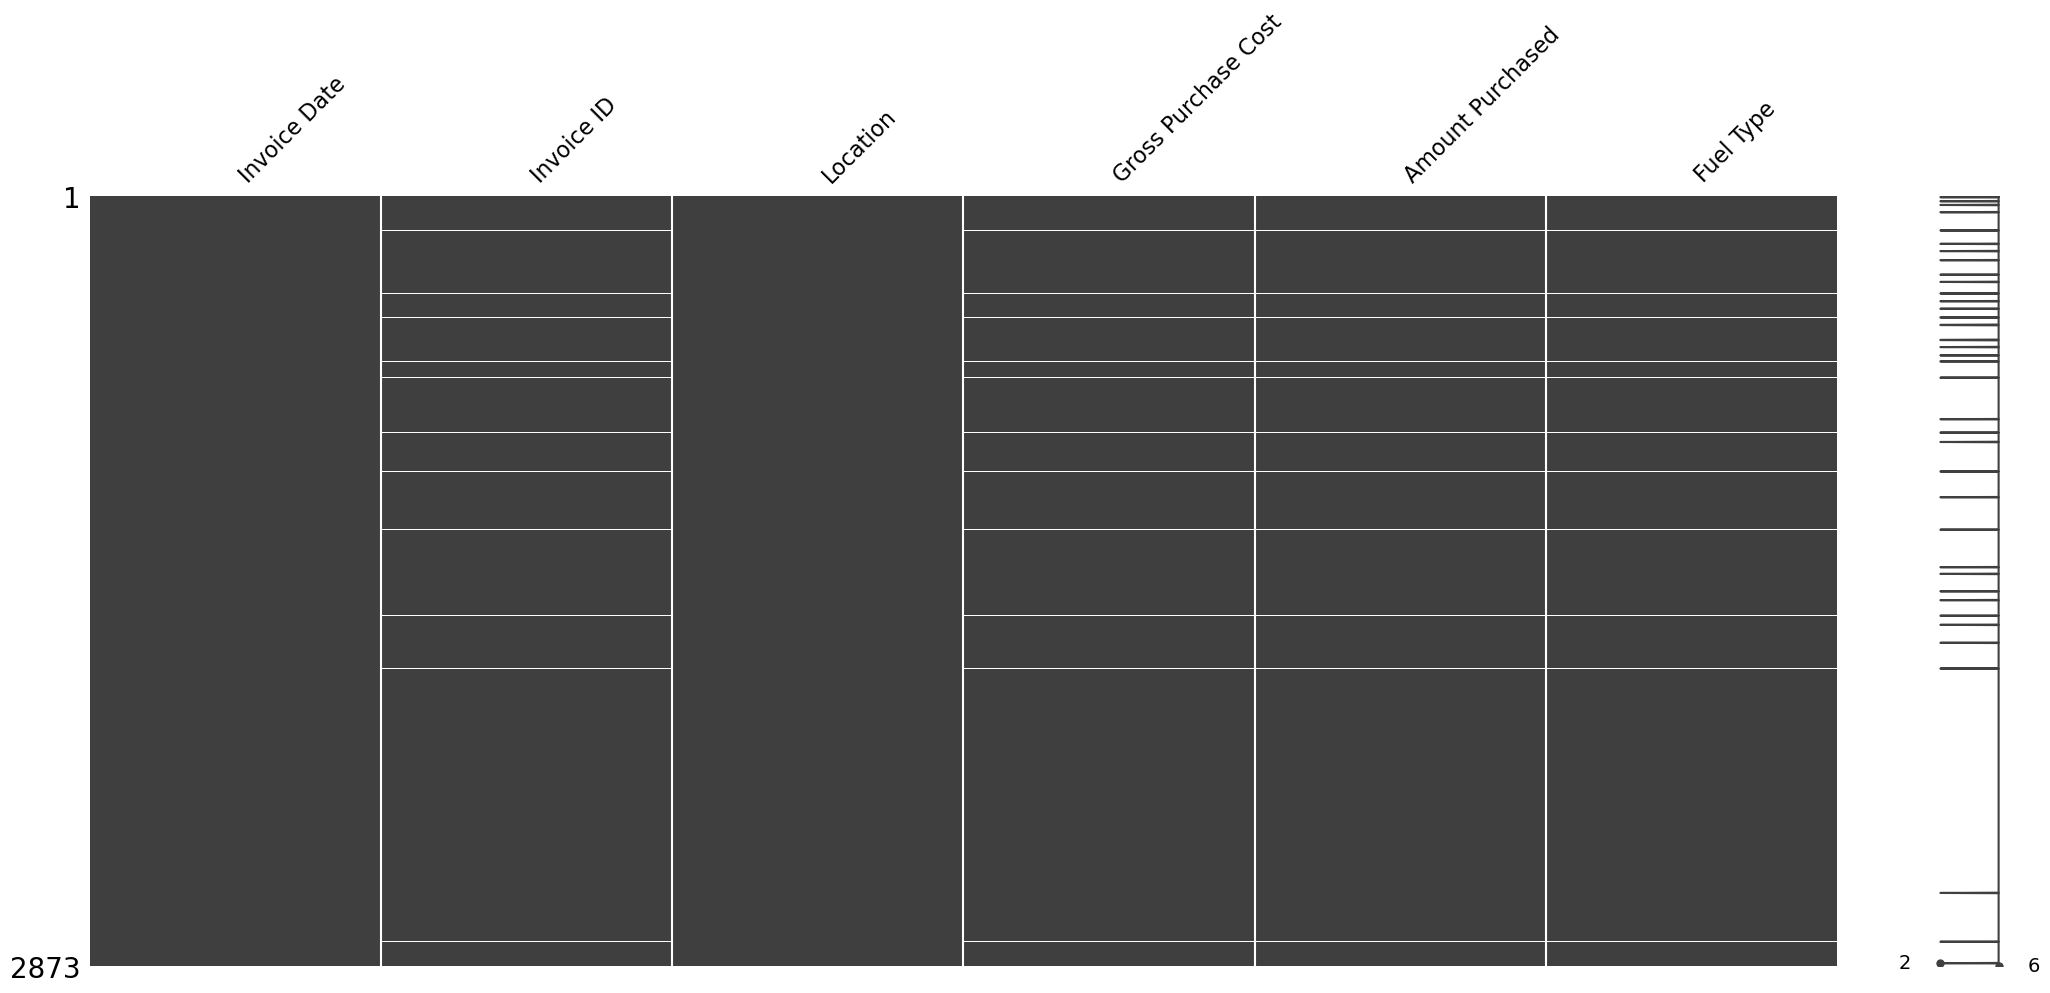

In [4]:
# check missing values
df_invoice.isna().any()
df_invoice.isna().sum()
# use matrix to see the missing values
msno.matrix(df_invoice)

# data cleaning
# drop entries without purchase cost / amount purchased
df_invoice = df_invoice.dropna(how = "any", subset = ["Gross Purchase Cost", "Amount Purchased"])
# check again to avoid missing values
df_invoice.isna().any()

#change ID into int
df_invoice["Invoice ID"] = df_invoice["Invoice ID"].astype(int)

# change timestamp to dates
df_invoice["Timestamp"] = pd.to_datetime(df_invoice["Invoice Date"])

# Consumption Patterns

## Construct df_cons

In [5]:
# merge dftank and dffuel
df_cons = df_fuel.merge(df_tank, on = 'Tank_ID', how = 'left')

# change timestamp to dates, only keep dates for further analysis
df_cons["Timestamp"] = pd.to_datetime(df_cons["Timestamp"])
df_cons["Timestamp"] = df_cons["Timestamp"].dt.normalize()

# add a new column assigning values for dates
date = df_cons["Timestamp"].unique()
num = {k:v for v,k in enumerate(date)}
df_cons["date_number"] = df_cons["Timestamp"].map(num)
df_cons["date_number"] = df_cons["date_number"] + 1

In [6]:
df_cons

,Tank_ID,Fuel_Level,Timestamp,Location,Tank Number,Tank Type,Tank Capacity,date_number
0,T 12,27161.0,2017-01-01,1,3,D,40000,1
1,T 12,27017.0,2017-01-01,1,3,D,40000,1
2,T 12,26934.0,2017-01-01,1,3,D,40000,1
3,T 12,26786.0,2017-01-01,1,3,D,40000,1
4,T 12,26748.0,2017-01-01,1,3,D,40000,1
...,...,...,...,...,...,...,...,...
1859653,T 32,27619.0,2019-08-15,8,2,U,40000,914
1859654,T 22,31548.0,2019-08-15,4,1,U,40000,914
1859655,T 16,53492.0,2019-08-15,2,1,U,70000,914
1859656,T 18,27081.0,2019-08-15,2,3,U,40000,914


In [7]:
# form two seperate df by fuel type
df_cons_gas = df_cons[df_cons["Tank Type"].isin (['U', 'P'])]
df_cons_diesel = df_cons[df_cons["Tank Type"] == 'D']

## Calculate daily consumption

### Calculate daily consumption without considering invoice (fuel level delta)

In [8]:
# in this step, we get the delta for each date and each tank_ID
# steps:
# (1) define a lambda function that accepts a parameter x and calculate the difference between 
    # first and last value for category x
# (2) group by 'date_number', 'Tank_ID', 'Timestamp', 'Tank Location', 'Tank Number', 'Tank Capacity','Tank Type'
# (3) rename the column 'Fuel_Level' to 'Delta', this means the consumption for each tank on different days

df_cons_diesel = df_cons_diesel.rename(columns = {'Tank Location': "Location"})
df_cons_gas = df_cons_gas.rename(columns = {'Tank Location': "Location"})

df_cons_temp_d = df_cons_diesel. groupby(by = [
    'date_number', 'Tank_ID', 'Timestamp', 'Location',
    'Tank Number', 'Tank Capacity','Tank Type']). agg(lambda x: -(x.iloc[-1] - x.iloc[0]))
df_cons_temp_g = df_cons_gas. groupby(by = [
    'date_number', 'Tank_ID', 'Timestamp', 'Location',
    'Tank Number', 'Tank Capacity','Tank Type']). agg(lambda x: -(x.iloc[-1] - x.iloc[0]))

df_cons_temp_d.rename(columns = {'Fuel_Level' : 'Delta'}, inplace = True)
df_cons_temp_g.rename(columns = {'Fuel_Level' : 'Delta'}, inplace = True)

In [9]:
# after we get the seperate consumption for each tank on different days (delta)
# we add all tanks within a specific tank location together
# get the total gas & diesel consumption for each gas station on different days

df_d = pd.DataFrame(df_cons_temp_d.groupby(by = ['date_number', 'Location']).Delta.sum())
df_g = pd.DataFrame(df_cons_temp_g.groupby(by = ['date_number', 'Location']).Delta.sum())
df_d.rename(columns = {'Delta': 'Diesel Consumption'}, inplace = True)
df_g.rename(columns = {'Delta': 'Gas Consumption'}, inplace = True)

In [10]:
# merge the diesel consumption with gas consumption together using outer join
# finally get the total consumption in different date, gas station and gas type

df_consumption = df_g.merge(df_d, on = ['date_number', 'Location'], how = 'outer')
df_consumption

Gas Consumption  Diesel Consumption
date_number Location                                     
1           1                 11637.0              5898.0
            2                  1669.0              1821.0
            3                     0.0                 4.0
            4                   -15.0                -3.0
            5                     8.0                 8.0
...                               ...                 ...
914         4                  2998.0              2373.0
            5                  2241.0               325.0
            6                   485.0                 0.0
            7                     0.0                19.0
            8                   848.0                 4.0

[6818 rows x 2 columns]

### Create df_purchased

In [11]:
# create amount purchased df
df_purchased = df_invoice.drop(columns = ["Gross Purchase Cost", "Invoice ID"])

# add date number to df
df_purchased["date_number"] = df_purchased["Invoice Date"].map(num)
df_purchased["date_number"] = df_purchased["date_number"] + 1
df_purchased["date_number"] = df_purchased["date_number"].astype('Int64')

# form two seperate df by fuel type
df_pgas = df_purchased[df_purchased["Fuel Type"] == 'G']
df_pdiesel = df_purchased[df_purchased["Fuel Type"] == 'D']

# calculate total amount purchased for each day at different gas station
df_purchased_gas = df_pgas.groupby(["date_number", "Location"]).sum(numeric_only = True)
df_purchased_diesel = df_pdiesel.groupby(["date_number", "Location"]).sum(numeric_only = True)

# rename columns
df_purchased_gas.rename(columns = {'Amount Purchased': "Gas Amount Purchased"}, inplace = True)
df_purchased_diesel.rename(columns = {'Amount Purchased': "Diesel Amount Purchased"}, inplace = True)

df_purchased_gas
df_purchased_diesel

Diesel Amount Purchased
date_number Location                         
2           1                        9338.736
            2                       22809.936
            4                        9139.200
            5                        7156.864
3           1                        4239.216
...                                       ...
908         5                        4134.688
911         1                        9301.232
913         2                       12479.600
            4                        7521.264
914         1                        4692.864

[1003 rows x 1 columns]

### Add back amount purchased for total consumption

In [12]:
# merge df
# for gas
df_gas_cons = df_g.merge(df_purchased_gas, on = ["date_number", "Location"], how = 'left')
# replace nan with 0
df_gas_cons.fillna(0, inplace = True)
# add a column for total
df_gas_cons["Total Gas Consumption"] = df_gas_cons["Gas Consumption"]+df_gas_cons["Gas Amount Purchased"]
df_gas_cons

# for diesel
df_diesel_cons = df_d.merge(df_purchased_diesel, on = ["date_number", "Location"], how = 'left')
df_diesel_cons.fillna(0, inplace = True)
df_diesel_cons["Total Diesel Consumption"] = df_diesel_cons["Diesel Consumption"]+df_diesel_cons["Diesel Amount Purchased"]
df_diesel_cons

# create final df for total consumption
df_total_cons = df_gas_cons.merge(df_diesel_cons, on = ["date_number", "Location"], how = 'left')
df_total_cons.head(3)

Gas Consumption  Gas Amount Purchased  \
date_number Location                                          
1           1                 11637.0                   0.0   
            2                  1669.0                   0.0   
            3                     0.0                   0.0   

                      Total Gas Consumption  Diesel Consumption  \
date_number Location                                              
1           1                       11637.0              5898.0   
            2                        1669.0              1821.0   
            3                           0.0                 4.0   

                      Diesel Amount Purchased  Total Diesel Consumption  
date_number Location                                                     
1           1                             0.0                    5898.0  
            2                             0.0                    1821.0  
            3                             0.0                       4.0

### Data cleaning for df_total_cons

In [13]:
# check negative values
df_total_cons["Total Gas Consumption"].lt(0).sum()
df_total_cons["Total Diesel Consumption"].lt(0).sum()

# drop all negative values
#df_total_cons = df_total_cons[(df_total_cons[["Total Gas Consumption", "Total Diesel Consumption"]] > 0).all(axis = 1)]

# turn all negative total consumption into 0
df_total_cons["Total Gas Consumption"] = df_total_cons["Total Gas Consumption"].apply(lambda x: x if x >= 0 else 0)
df_total_cons["Total Diesel Consumption"] = df_total_cons["Total Diesel Consumption"].apply(lambda x: x if x >= 0 else 0)

In [14]:
# add back timestamp
df_t = df_cons[["date_number", "Timestamp"]]
df_t = df_t.drop_duplicates(subset="Timestamp")
df_t = df_t.reset_index().drop(columns = "index")
df_total_cons

Gas Consumption  Gas Amount Purchased  \
date_number Location                                          
1           1                 11637.0                   0.0   
            2                  1669.0                   0.0   
            3                     0.0                   0.0   
            4                   -15.0                   0.0   
            5                     8.0                   0.0   
...                               ...                   ...   
914         4                  2998.0                   0.0   
            5                  2241.0                   0.0   
            6                   485.0                   0.0   
            7                     0.0                   0.0   
            8                   848.0                   0.0   

                      Total Gas Consumption  Diesel Consumption  \
date_number Location                                              
1           1                       11637.0              5898.0   
            2                        1669.0              1821.0   
            3                           0.0                 4.0   
            4                           0.0                -3.0   
            5                           8.0                 8.0   
...                                     ...                 ...   
914         4                        2998.0              2373.0   
            5                        2241.0               325.0   
            6                         485.0                 0.0   
            7                           0.0                19.0   
            8                         848.0                 4.0   

                      Diesel Amount Purchased  Total Diesel Consumption  
date_number Location                                                     
1           1                             0.0                    5898.0  
            2                             0.0                    1821.0  
            3                             0.0                       4.0  
            4                             0.0                       0.0  
            5                             0.0                       8.0  
...                                       ...                       ...  
914         4                             0.0                    2373.0  
            5                             0.0                     325.0  
            6                             0.0                       0.0  
            7                             0.0                      19.0  
            8                             0.0                       4.0  

[6818 rows x 6 columns]

In [15]:
# add back timestamp
df_t = df_cons[["date_number", "Timestamp"]]
df_t = df_t.drop_duplicates(subset="Timestamp")
df_t = df_t.reset_index().drop(columns = "index")

df_c = df_total_cons.reset_index()

df_total_cons = df_c.merge(df_t, on= "date_number", how = "outer", validate='many_to_one')

In [16]:
# add gas station names
df_total_cons = df_total_cons.merge(df_loc[['Gas Station Name', 'Location']], on = ['Location'], how = 'left')
df_total_cons

,date_number,Location,Gas Consumption,Gas Amount Purchased,Total Gas Consumption,Diesel Consumption,Diesel Amount Purchased,Total Diesel Consumption,Timestamp,Gas Station Name
0,1,1,11637.0,0.0,11637.0,5898.0,0.0,5898.0,2017-01-01,EastMount
1,1,2,1669.0,0.0,1669.0,1821.0,0.0,1821.0,2017-01-01,Eastgate
2,1,3,0.0,0.0,0.0,4.0,0.0,4.0,2017-01-01,Central
3,1,4,-15.0,0.0,0.0,-3.0,0.0,0.0,2017-01-01,Chedoke
4,1,5,8.0,0.0,8.0,8.0,0.0,8.0,2017-01-01,Mountain View
...,...,...,...,...,...,...,...,...,...,...
6813,914,4,2998.0,0.0,2998.0,2373.0,0.0,2373.0,2019-08-15,Chedoke
6814,914,5,2241.0,0.0,2241.0,325.0,0.0,325.0,2019-08-15,Mountain View
6815,914,6,485.0,0.0,485.0,0.0,0.0,0.0,2019-08-15,Oakville
6816,914,7,0.0,0.0,0.0,19.0,0.0,19.0,2019-08-15,Circle


## Plot 1 - total gas and diesel consumptions for different gas stations

In [17]:
# summarize all records for each gas station on different days and calculate the sum for 
# 'Total Gas Consumption', 'Total Diesel Consumption'.

total_cons_loc = pd.DataFrame(df_total_cons.groupby(by = ['Location', 'Gas Station Name'], as_index=False)
                              [['Total Gas Consumption', 'Total Diesel Consumption']].sum())

# add a new column 'Total Consumption', which is the sum for gas and diesel consumption
# then calculate the proportion for gas and diesel
total_cons_loc["Total Consumption"] = total_cons_loc["Total Gas Consumption"] + total_cons_loc["Total Diesel Consumption"]
total_cons_loc['Gas proportion'] = total_cons_loc['Total Gas Consumption']/ total_cons_loc['Total Consumption']
total_cons_loc['Diesel proportion'] = total_cons_loc['Total Diesel Consumption']/ total_cons_loc['Total Consumption']

/var/folders/x5/8s_ngsq976v6tf3f1pqz9tgc0000gn/T/ipykernel_20227/171310171.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(total_cons_loc['Gas Station Name'], rotation = 45)


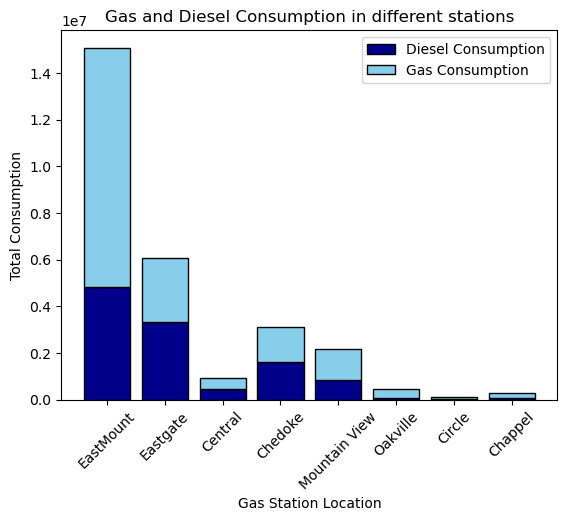

In [18]:
# draw a bar plot that shows the total gas and total diesel consumption 
# for each gas station over the given time range

fig, ax = plt.subplots()

# create a barplot for diesel consumption
ax.bar(total_cons_loc['Gas Station Name'],
       total_cons_loc['Total Diesel Consumption'],
       color = 'darkblue',
       edgecolor = 'black',
       label = 'Diesel Consumption')

# create a barplot for gas consumption, and set bottom begins from Total Diesel Consumption
ax.bar(total_cons_loc["Gas Station Name"], 
       total_cons_loc['Total Gas Consumption'], 
       bottom = total_cons_loc['Total Diesel Consumption'],
       color = 'skyblue',
       edgecolor = 'black',
       label = 'Gas Consumption')

# set the label for x and y axis, then add title for the graph
ax.set(xlabel = 'Gas Station Location', ylabel = 'Total Consumption', 
       title = 'Gas and Diesel Consumption in different stations')    

# rotate the gas station name so they won't overlap between each other
ax.set_xticklabels(total_cons_loc['Gas Station Name'], rotation = 45)

ax.legend();

## Plot 2 - Gas and Diesel consumption proportions in different stations

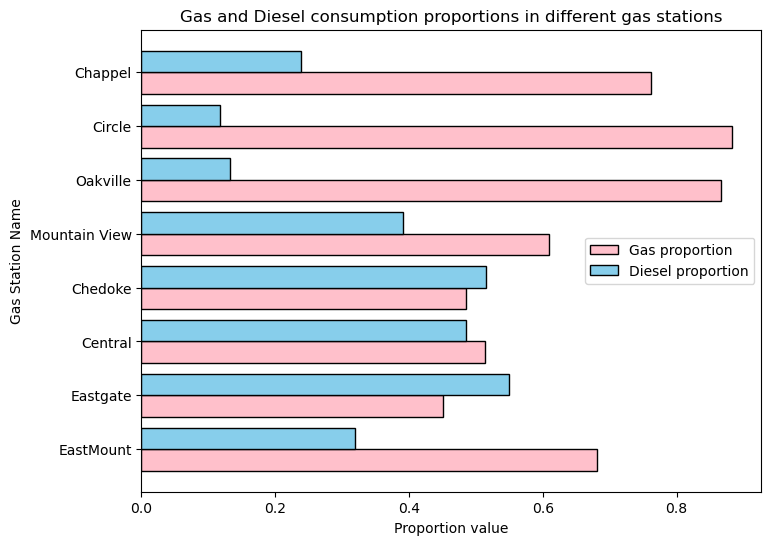

In [19]:
# set labels and bar width
labels = list(total_cons_loc['Gas Station Name'])
positions = np.arange(len(labels))
bar_width = 0.4

# draw a barh plot showing the proportions for gas consumption and diesel consumption
# editing the position of the barh so that they don't overlap with each other
fig, ax = plt.subplots(figsize = (8, 6))
bar_1 = ax.barh(positions - bar_width/2,total_cons_loc['Gas proportion'], 
                bar_width, label='Gas proportion', color="pink", edgecolor = 'black')
bar_2 = ax.barh(positions + bar_width/2,total_cons_loc['Diesel proportion'], 
                bar_width, label='Diesel proportion', color="skyblue", edgecolor = 'black')

# set yticks, xlabel, ylabel and title
plt.yticks(positions, labels)
ax.set(xlabel = 'Proportion value', ylabel = 'Gas Station Name', 
       title = 'Gas and Diesel consumption proportions in different gas stations')

ax.legend();

## Plot 3 - avg. daily fuel comsumption for different gas stations

In [20]:
# transform df for average daily consumptions
# calculate sum of gas consumption at each gas station, then find avg.
df1 = df_total_cons.reset_index()
df1 = df1[["Location", "Total Gas Consumption"]].groupby("Location").sum()
df1["Average Gas Consumption"] = df1["Total Gas Consumption"] / df_total_cons["date_number"].max()
df1

# calculate sum of diesel consumption at each gas station, then find avg.
df2 = df_total_cons.reset_index()
df2 = df2[["Location", "Total Diesel Consumption"]].groupby("Location").sum()
df2["Average Diesel Consumption"] = df2["Total Diesel Consumption"] / df_total_cons["date_number"].max()
df2

# merge 2 df for plotting, edit columns for value precisions
df3 = df1.merge(df2, on = "Location", how = "left")
df3 = df3.reset_index()
df3["Average Gas Consumption"] = df3["Average Gas Consumption"].apply(lambda x: round(x))
df3["Average Diesel Consumption"] = df3["Average Diesel Consumption"].apply(lambda x: round(x))
df3

,Location,Total Gas Consumption,Average Gas Consumption,Total Diesel Consumption,Average Diesel Consumption
0,1,1.028e+07,11245,4.810e+06,5263
1,2,2.739e+06,2997,3.341e+06,3655
2,3,4.802e+05,525,4.539e+05,497
3,4,1.509e+06,1651,1.606e+06,1757
4,5,1.319e+06,1443,8.460e+05,926
5,6,3.934e+05,430,6.031e+04,66
6,7,9.208e+04,101,1.224e+04,13
7,8,2.082e+05,228,6.498e+04,71


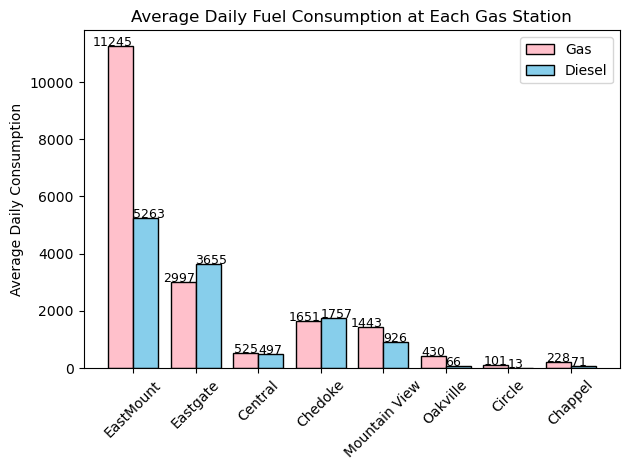

In [22]:
labels = list(df_loc["Gas Station Name"])

# set label locations and bar width
x = np.arange(len(labels))
width = 0.4      

fig3, ax3 = plt.subplots()

# avoid overlapping by deduction and adding width/2
bar_1 = ax3.bar(x - width/2, df3["Average Gas Consumption"], 
                width, label='Gas', color="pink", edgecolor = 'black')
bar_2 = ax3.bar(x + width/2, df3["Average Diesel Consumption"], 
                width, label='Diesel', color="skyblue", edgecolor = 'black')

# add values for each bar
def value1(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'right', fontsize = 9)
def value2(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'left', fontsize = 9)
        
value1(df3["Location"], df3["Average Gas Consumption"])
value2(df3["Location"], df3["Average Diesel Consumption"])

# add some text for labels, title and custom x-axis
ax3.set_ylabel('Average Daily Consumption')
ax3.set_title('Average Daily Fuel Consumption at Each Gas Station')
ax3.set_xticks(x)
ax3.set_xticklabels(labels, rotation=45)
ax3.legend()

fig3.tight_layout()
#plt.savefig('daily average.png', bbox_inches='tight')
plt.show()

## Plot 4 - daily fuel consumption trend at each gas station

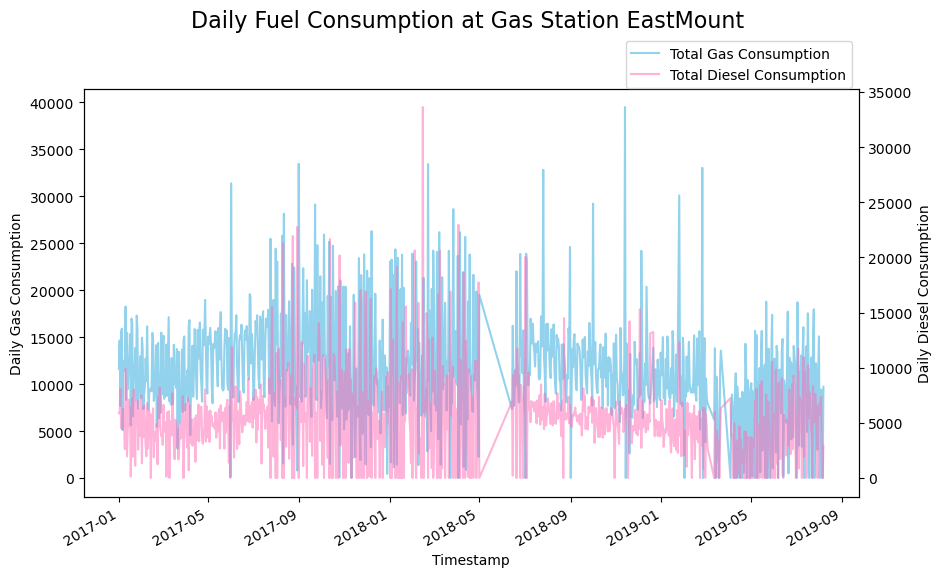

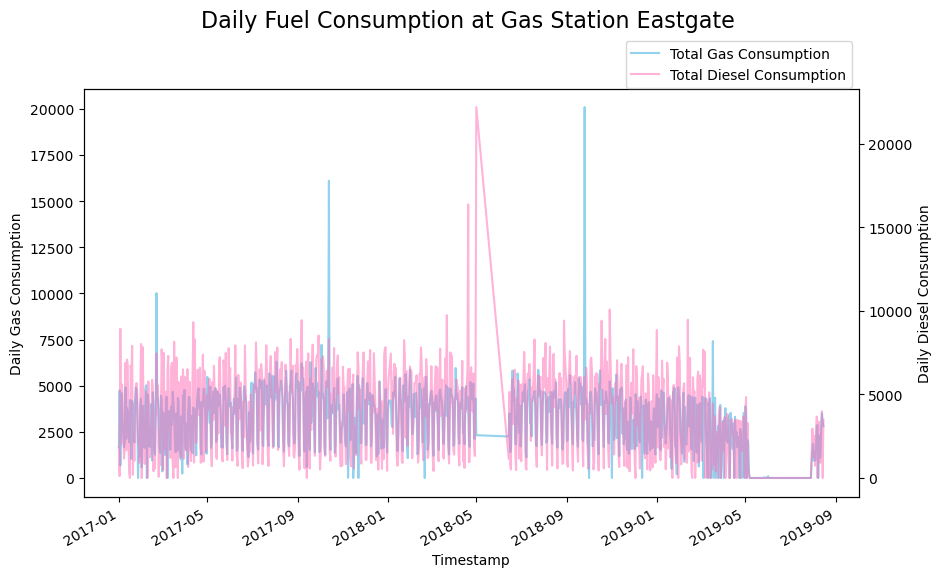

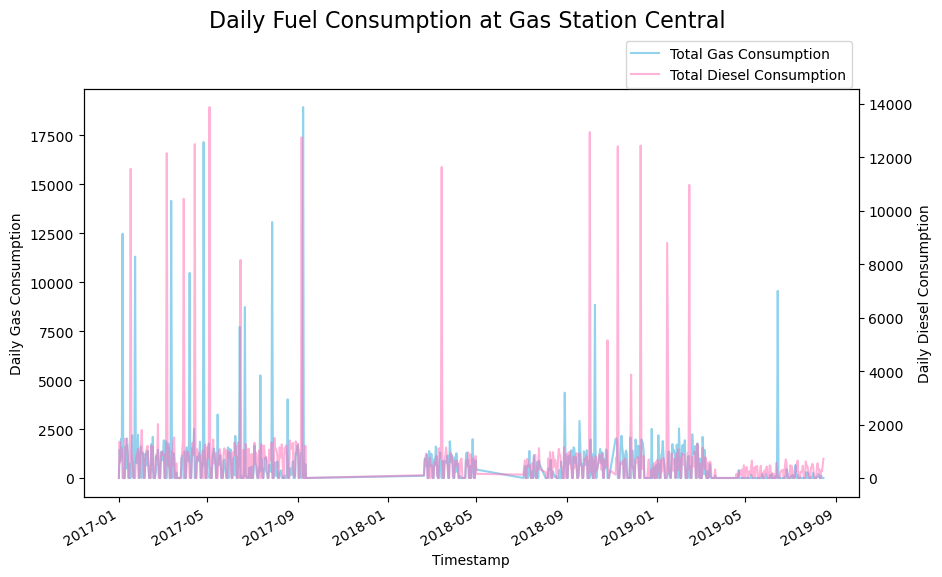

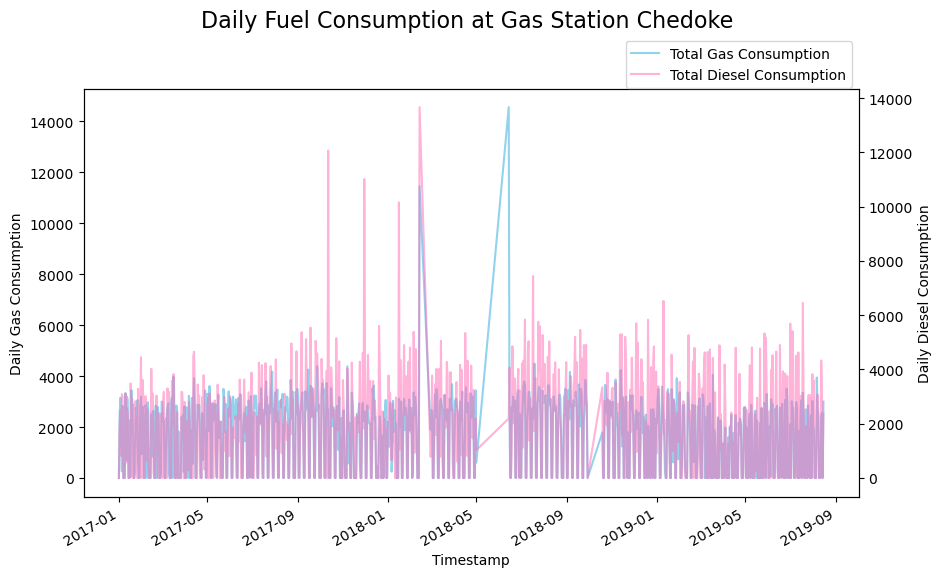

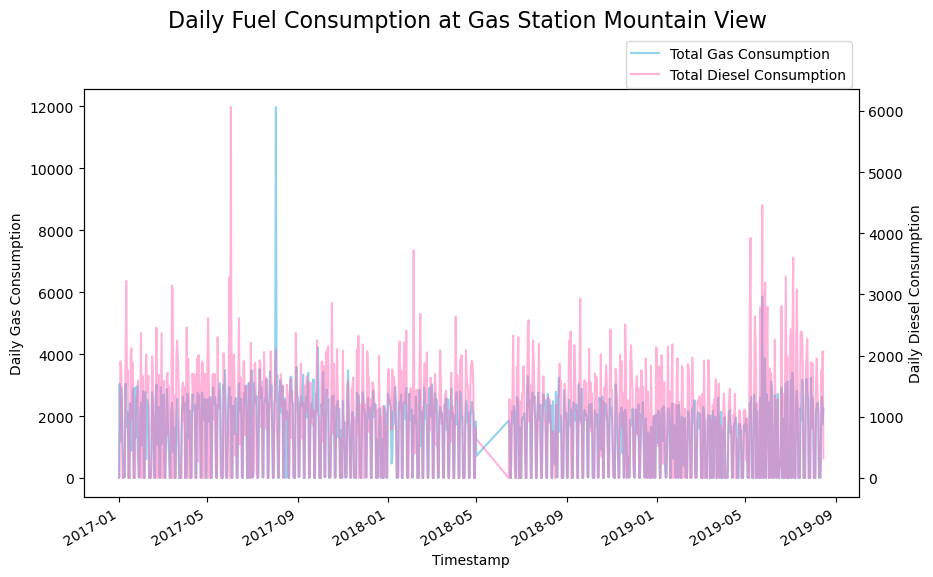

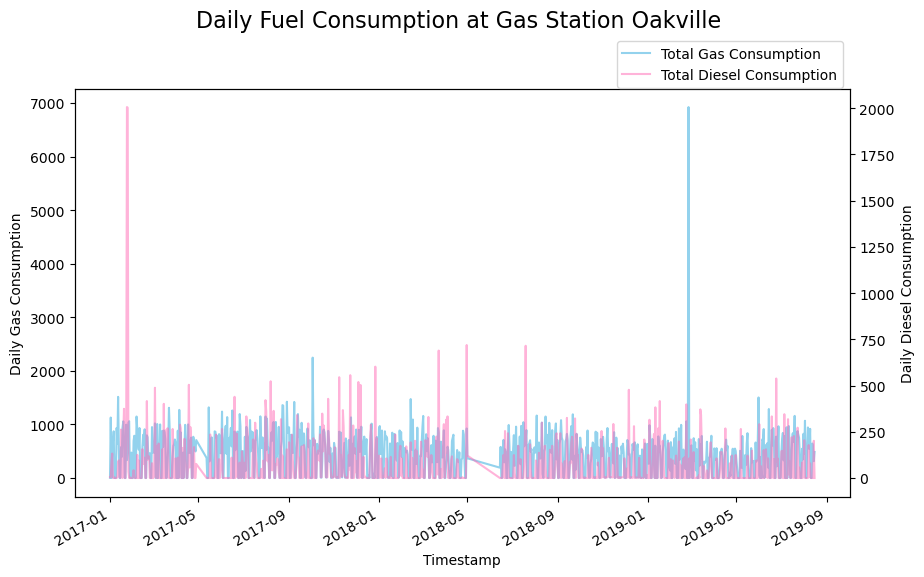

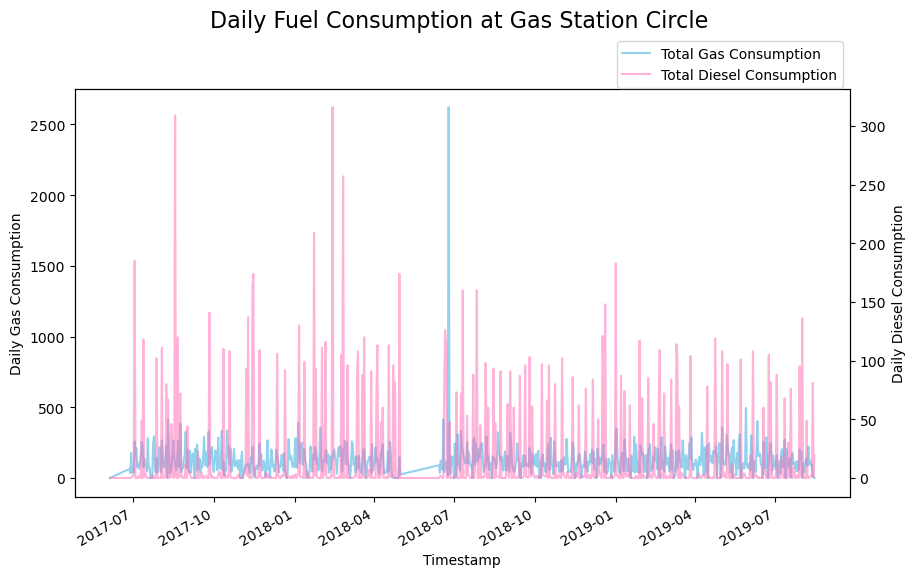

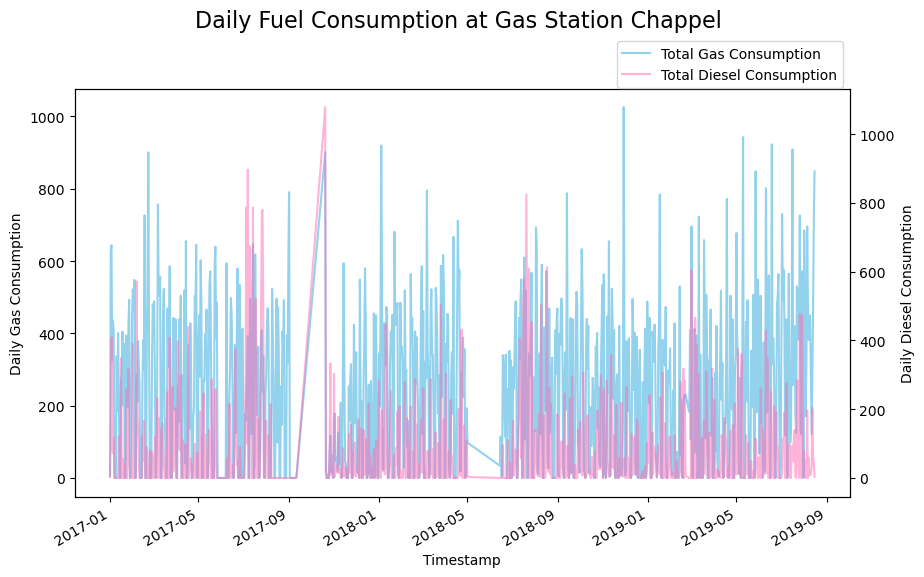

In [23]:
# loop for gas station 1-8, find daily consumption line chart
for i in range(1,9):
    # find gas station name
    names = list(df_loc["Gas Station Name"])
    n = names[i-1]
    
    # filter data for gas station i
    dfi = df_total_cons.reset_index()
    dfi = dfi[dfi["Location"] == i]
    
    # line plot for gas station i
    # first line with gas
    axi = dfi.plot(x="Timestamp", y="Total Gas Consumption", legend=False,
                   color="skyblue", alpha=0.9, figsize=(10,6))
    axii = axi.twinx()
    # second line with diesel
    dfi.plot(x="Timestamp", y="Total Diesel Consumption", ax=axii,
             legend=False, color="hotpink", alpha=0.5)
    # set labels, title, legend location
    axi.set_title(f'Daily Fuel Consumption at Gas Station {n} \n \n', loc='center', fontsize = 16)
    axi.figure.legend(bbox_to_anchor=(0.9,0.97))
    axi.set_ylabel("Daily Gas Consumption")
    axii.set_ylabel("Daily Diesel Consumption")
    
    #axi.set_facecolor("lightgrey")
    # save plots
    #plt.savefig(f'daily {n}.png', bbox_inches='tight')
    
    plt.show()

## Plot 5 - Gas station location

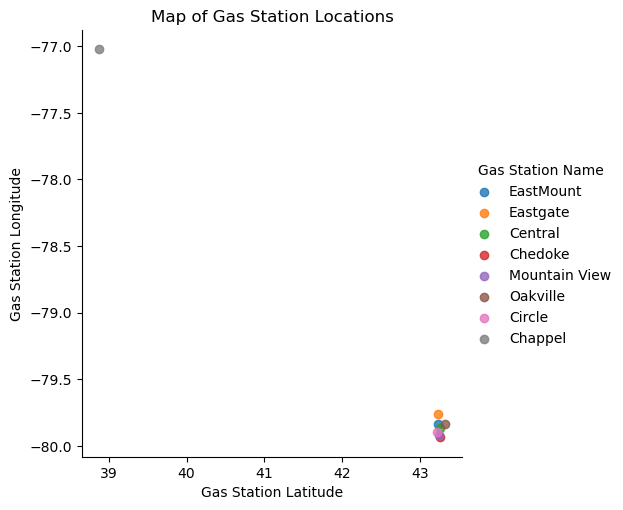

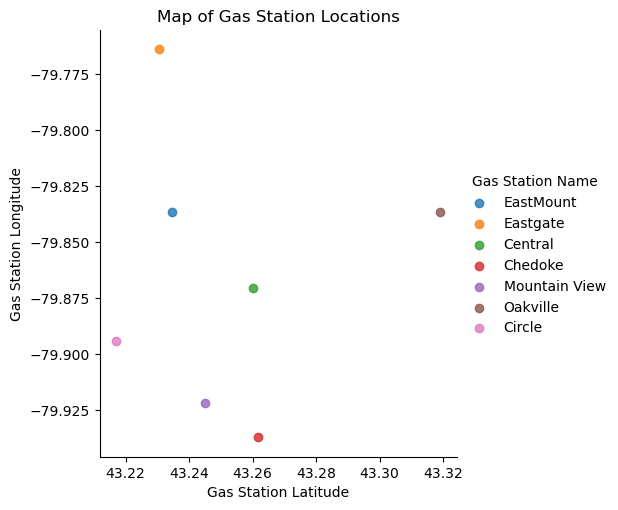

In [24]:
# 8 gas station locations distribution
sns.lmplot(x = "Gas Station Latitude", y = "Gas Station Longitude",
           data = df_loc, hue = "Gas Station Name", fit_reg=False)
plt.title("Map of Gas Station Locations")
plt.show()

# drop gas station 8 for clearer view at rest of the gas station locations
df_loc2 = df_loc[:-1]
df_loc2

sns.lmplot(x = "Gas Station Latitude", y = "Gas Station Longitude", data=df_loc2, \
           hue = "Gas Station Name", fit_reg = False)
plt.title("Map of Gas Station Locations")
plt.show()

# Purchasing Patterns

## Create df_station

In [25]:
# using left join to merge df_loc and df_tank on station location
df_loc_tanks_merge = df_loc.merge(df_tank, left_on = 'Location', right_on = 'Location', how = 'left')
# using left join to merge df_loc and df_invoice on station location
df_loc_invoice_merge = df_loc.merge(df_invoice, left_on = 'Location', \
                                    right_on = 'Location', how = 'left')

# drop specific columns from df_loc_invoice_merge, retaining only data useful for subsequent analysis
df_station = df_loc_invoice_merge.drop(columns = ['Gas Station Name', 'Gas Station Address', \
                                                  'Gas Station Latitude', 'Gas Station Longitude'])

# rename the columns
df_station.rename(columns = {'Invoice Date' : 'Invoice_Date', \
                             'Invoice ID' : 'Invoice_ID', 
                            'Gross Purchase Cost' : 'Gross_Purchase_Cost', \
                             'Amount Purchased' : 'Amount_Purchased', 'Fuel Type' : 'Fuel_Type'}, inplace = True)

# drop repeated columns
df_station.drop(columns="Invoice_Date", inplace = True)

# split the data by 'Month', 'Fuel_Type' and 'Gas_Station_Location'
df_station['Month'] = df_station['Timestamp'].dt.month
station_purchase = df_station.groupby(["Month", "Fuel_Type", "Location"]).Amount_Purchased.sum()
# transforming the serie into a dataframe
df_station_purchase = station_purchase.loc[1:].to_frame()

In [26]:
df_station

,Location,Invoice_ID,Gross_Purchase_Cost,Amount_Purchased,Fuel_Type,Timestamp,Month
0,1,10000,7570.820,6609.600,G,2017-01-02,1
1,1,10001,12491.853,9338.736,D,2017-01-02,1
2,1,10006,5670.544,4239.216,D,2017-01-03,1
3,1,10007,7627.601,6659.184,G,2017-01-03,1
4,1,10008,32175.985,26704.960,G,2017-01-03,1
...,...,...,...,...,...,...,...
2826,8,12579,11863.475,7037.712,G,2019-05-07,5
2827,8,12655,7495.112,5231.008,G,2019-06-06,6
2828,8,12742,12359.364,9056.336,G,2019-07-09,7
2829,8,12795,5678.115,3158.640,D,2019-07-30,7


## Plot 1 - Gross purcahse cost at each gas station

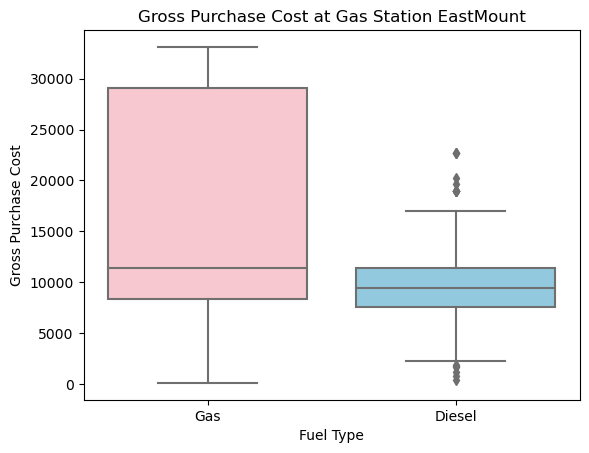

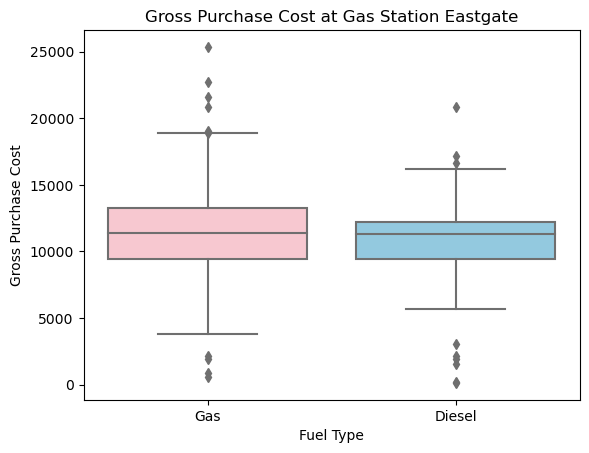

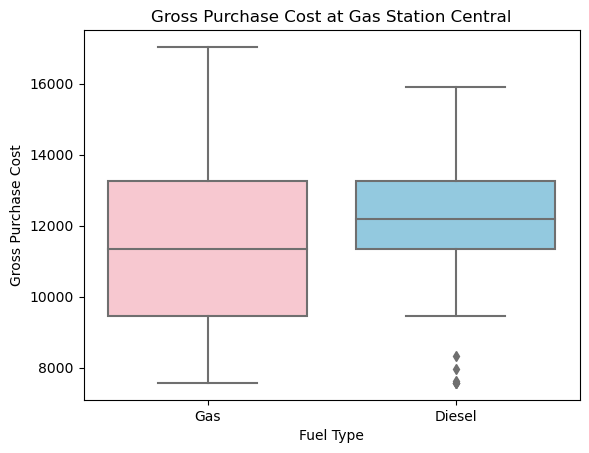

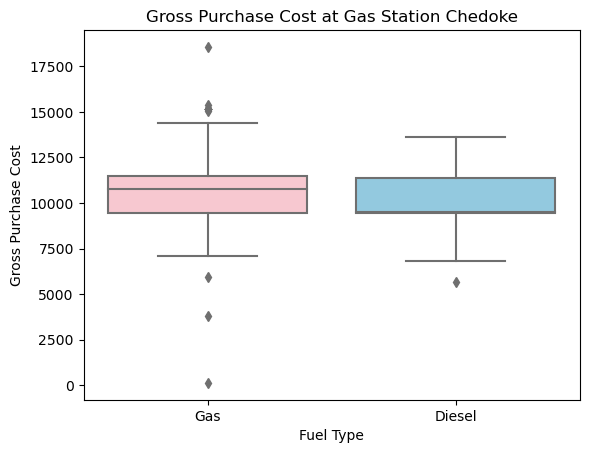

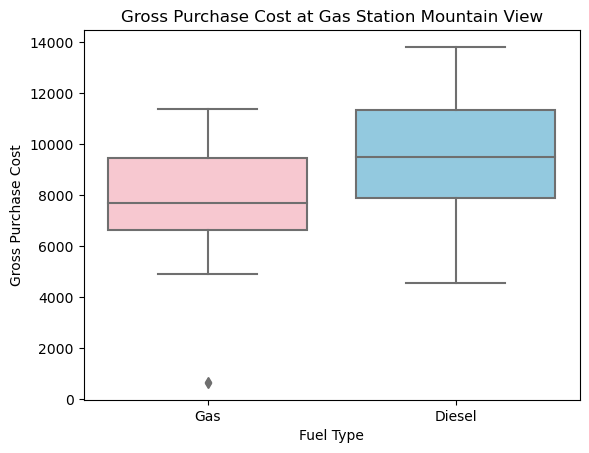

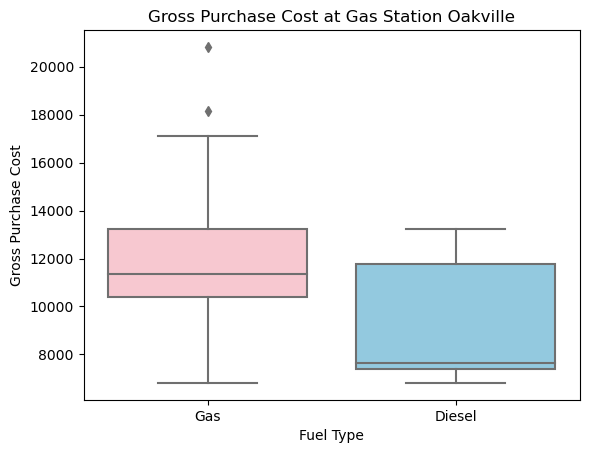

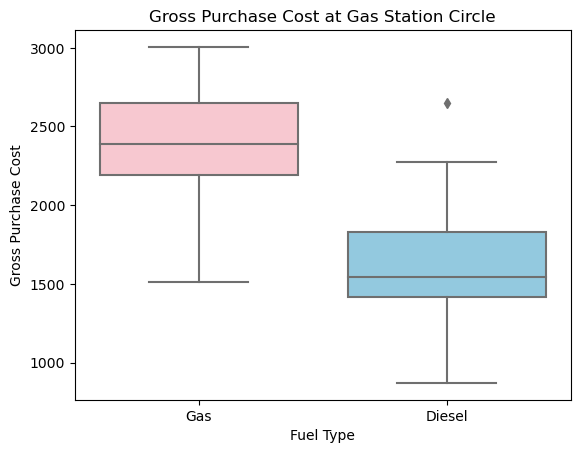

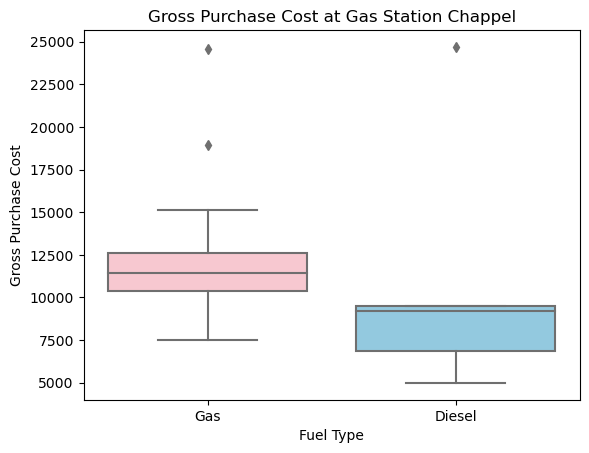

In [27]:
# draw a box plot of gross cost in each gas station
for n in range(1,9):
    # find gas station name
    names = list(df_loc["Gas Station Name"])
    name = names[n-1]
    
    # filter and create a df for single gas station
    df_costn = df_invoice[df_invoice["Location"] == n]

    # draw a box plot with fuel type as categorical, label x axis
    axn = sns.boxplot(data=df_costn, x="Fuel Type", y="Gross Purchase Cost", palette=["pink","skyblue"])
    axn.set(xlabel="Fuel Type", xticklabels=["Gas", "Diesel"])
    axn.set_title(f'Gross Purchase Cost at Gas Station {name}')
    #plt.savefig(f'Cost at Gas Sation {name}.png', bbox_inches='tight')
    plt.show()

## Plot 2 - Histogram of amount purchased per year

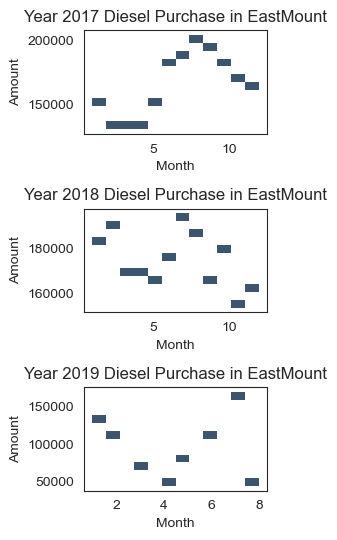

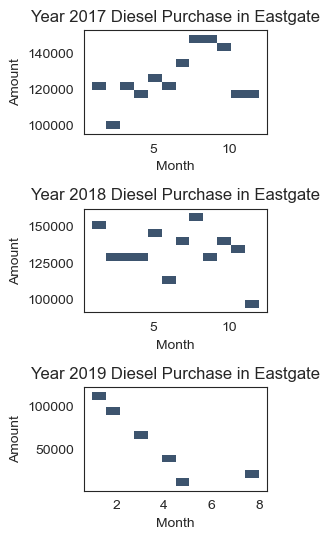

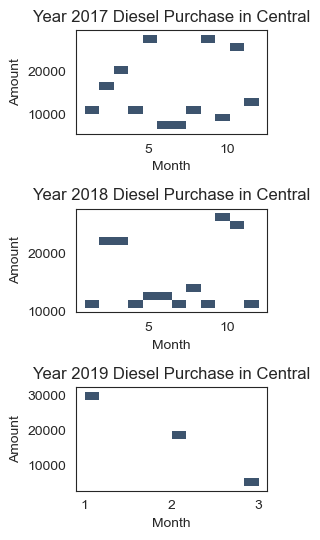

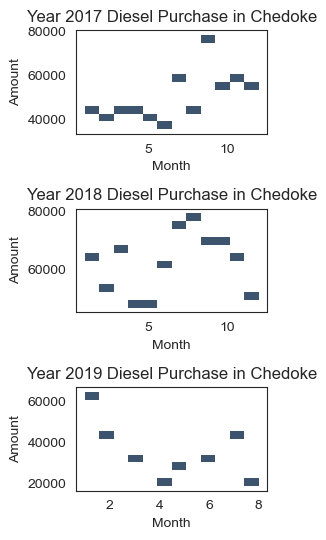

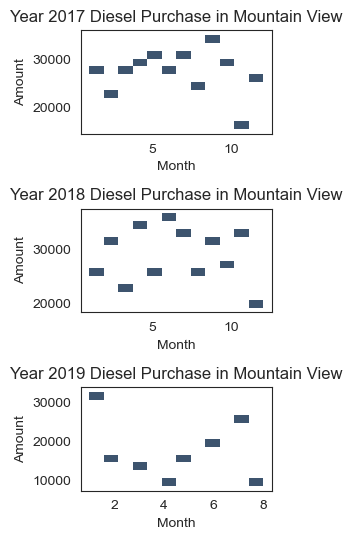

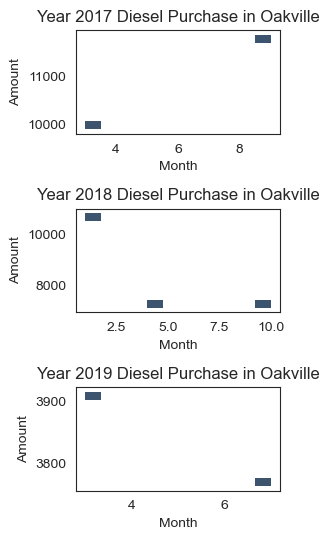

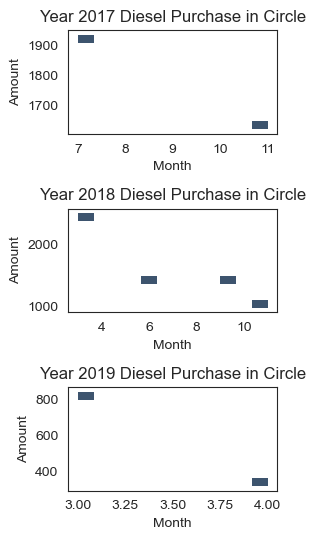

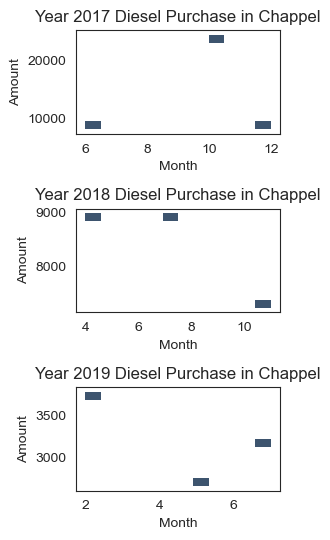

In [28]:
# loop for each station
# the purchase of diesel
for i in range(1,9):
 
    df_station_i = df_station[df_station["Location"] == i]
    
    # pick the purchasing data of each station in 2017
    df_station_2017_i = df_station_i[df_station_i['Timestamp'].dt.year == 2017]
    df_station_2017_i = df_station_2017_i[df_station_2017_i['Timestamp'].notnull()].copy()
    
    # add a new column 'Month', picking the month of each transaction
    df_station_2017_i['Month'] = df_station_2017_i['Timestamp'].dt.month
    # group the data by 'Month' and 'Fuel_Type'
    sta_2017_month_purchase_i = df_station_2017_i.groupby(["Month", "Fuel_Type"]).Amount_Purchased.sum()
    
    # transforming the serie into a dataframe
    df_2017_month_purchase_i = sta_2017_month_purchase_i.loc[1:].to_frame()
    # pick the data which Fuel_type = D
    df_2017_month_purchase_i.groupby("Fuel_Type").get_group("D")
    
    # pick the purchasing data of each station in 2018
    df_station_2018_i = df_station_i[df_station_i['Timestamp'].dt.year == 2018]
    df_station_2018_i = df_station_2018_i[df_station_2018_i['Timestamp'].notnull()].copy()
    
    # add a new column 'Month', picking the month of each transaction
    df_station_2018_i['Month'] = df_station_2018_i['Timestamp'].dt.month
    # group the data by 'Month' and 'Fuel_Type'
    sta_2018_month_purchase_i = df_station_2018_i.groupby(["Month", "Fuel_Type"]).Amount_Purchased.sum()
    
    # transforming the serie into a dataframe
    df_2018_month_purchase_i = sta_2018_month_purchase_i.loc[1:].to_frame()
    # pick the data which Fuel_type = D
    df_2018_month_purchase_i.groupby("Fuel_Type").get_group("D")
    
    # pick the purchasing data of each station in 2019
    df_station_2019_i = df_station_i[df_station_i['Timestamp'].dt.year == 2019]
    df_station_2019_i = df_station_2019_i[df_station_2019_i['Timestamp'].notnull()].copy()
    
    # add a new column 'Month', picking the month of each transaction
    df_station_2019_i['Month'] = df_station_2019_i['Timestamp'].dt.month
    # group the data by 'Month' and 'Fuel_Type'
    sta_2019_month_purchase_i = df_station_2019_i.groupby(["Month", "Fuel_Type"]).Amount_Purchased.sum()
    
    # transforming the serie into a dataframe
    df_2019_month_purchase_i = sta_2019_month_purchase_i.loc[1:].to_frame()
    # pick the data which Fuel_type = D
    df_2019_month_purchase_i.groupby("Fuel_Type").get_group("D")

    names = list(df_loc["Gas Station Name"])
    name = names[i-1]
    #set seaborn plotting aesthetics as default
    sns.set_style('white')

    #define plotting region (1 rows, 3 columns)
    fig, axes = plt.subplots(3, 1, figsize = (3, 5.5))


    #create histplot in each subplot, representing the purchase of Diesel
    # each year from 2017 - 2019 for each station
    sns.histplot(data=df_2017_month_purchase_i.groupby("Fuel_Type").get_group("D"),
                 x="Month", y='Amount_Purchased',ax=axes[0], bins = 12)
    axes[0].set(xlabel = "Month", ylabel = "Amount", 
                title = f"Year 2017 Diesel Purchase in {name}")
    
    
    sns.histplot(data=df_2018_month_purchase_i.groupby("Fuel_Type").get_group("D"),
                 x="Month", y='Amount_Purchased', ax=axes[1], bins = 12)
    axes[1].set(xlabel = "Month", ylabel = "Amount",
                title = f"Year 2018 Diesel Purchase in {name}")
    
    
    sns.histplot(data=df_2019_month_purchase_i.groupby("Fuel_Type").get_group("D"),
                 x="Month", y='Amount_Purchased', ax=axes[2], bins = 12)
    axes[2].set(xlabel = "Month", ylabel = "Amount",
                title = f"Year 2019 Diesel Purchase in {name}")
    plt.tight_layout()

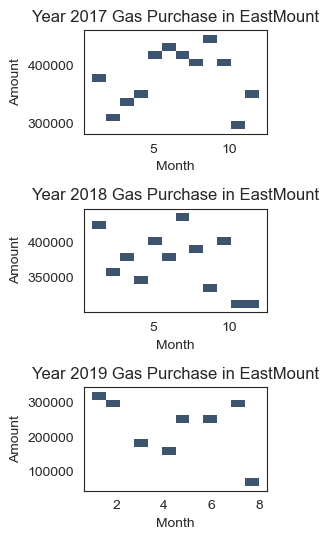

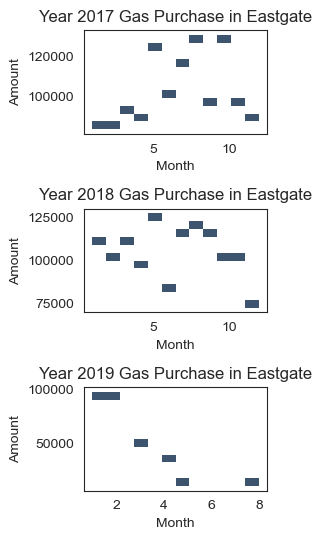

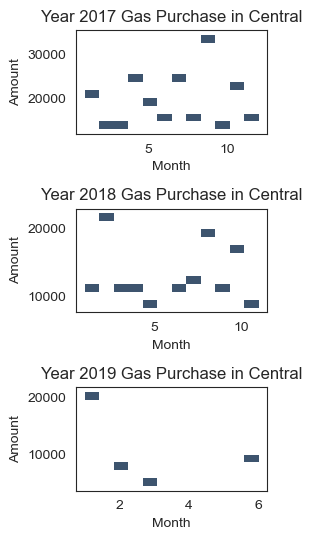

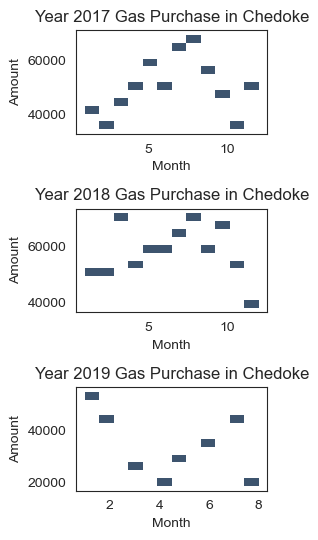

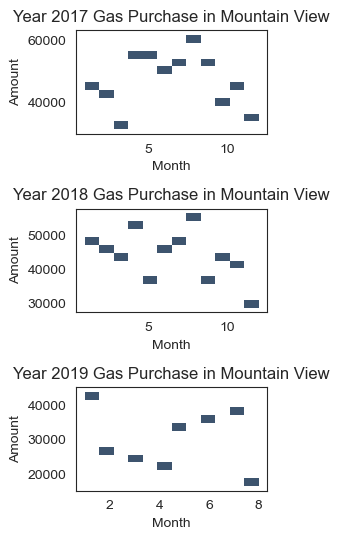

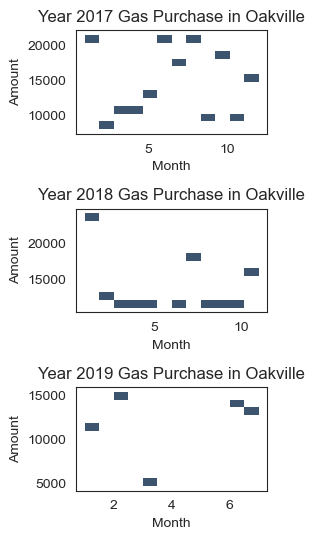

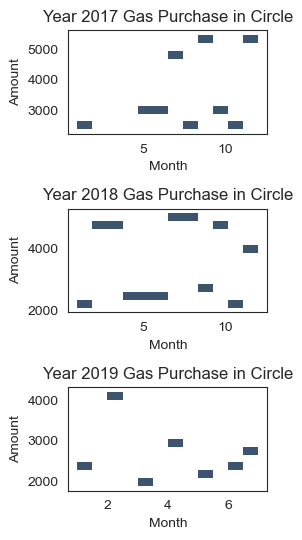

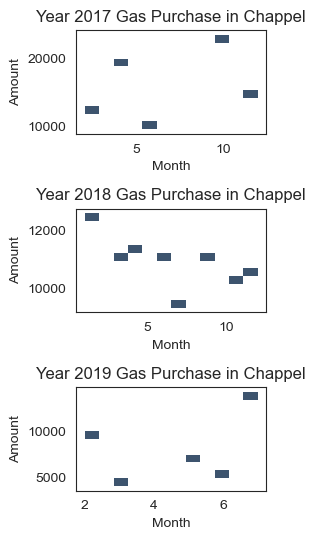

In [29]:
# loop for each station
# the purchase of diesel
for i in range(1,9):
 
    df_station_i = df_station[df_station["Location"] == i]
    
    # pick the purchasing data of each station in 2017
    df_station_2017_i = df_station_i[df_station_i['Timestamp'].dt.year == 2017]
    df_station_2017_i = df_station_2017_i[df_station_2017_i['Timestamp'].notnull()].copy()
    
    # add a new column 'Month', picking the month of each transaction
    df_station_2017_i['Month'] = df_station_2017_i['Timestamp'].dt.month
    # group the data by 'Month' and 'Fuel_Type'
    sta_2017_month_purchase_i = df_station_2017_i.groupby(["Month", "Fuel_Type"]).Amount_Purchased.sum()
    
    # transforming the serie into a dataframe
    df_2017_month_purchase_i = sta_2017_month_purchase_i.loc[1:].to_frame()
    # pick the data which Fuel_type = G
    df_2017_month_purchase_i.groupby("Fuel_Type").get_group("G")
    
    # pick the purchasing data of each station in 2018
    df_station_2018_i = df_station_i[df_station_i['Timestamp'].dt.year == 2018]
    df_station_2018_i = df_station_2018_i[df_station_2018_i['Timestamp'].notnull()].copy()
    
    # add a new column 'Month', picking the month of each transaction
    df_station_2018_i['Month'] = df_station_2018_i['Timestamp'].dt.month
    # group the data by 'Month' and 'Fuel_Type'
    sta_2018_month_purchase_i = df_station_2018_i.groupby(["Month", "Fuel_Type"]).Amount_Purchased.sum()
    
    # transforming the serie into a dataframe
    df_2018_month_purchase_i = sta_2018_month_purchase_i.loc[1:].to_frame()
    # pick the data which Fuel_type = G
    df_2018_month_purchase_i.groupby("Fuel_Type").get_group("G")
    
    # pick the purchasing data of each station in 2019
    df_station_2019_i = df_station_i[df_station_i['Timestamp'].dt.year == 2019]
    df_station_2019_i = df_station_2019_i[df_station_2019_i['Timestamp'].notnull()].copy()
    
    # add a new column 'Month', picking the month of each transaction
    df_station_2019_i['Month'] = df_station_2019_i['Timestamp'].dt.month
    # group the data by 'Month' and 'Fuel_Type'
    sta_2019_month_purchase_i = df_station_2019_i.groupby(["Month", "Fuel_Type"]).Amount_Purchased.sum()
    
    # transforming the serie into a dataframe
    df_2019_month_purchase_i = sta_2019_month_purchase_i.loc[1:].to_frame()
    # pick the data which Fuel_type = G
    df_2019_month_purchase_i.groupby("Fuel_Type").get_group("G")

    names = list(df_loc["Gas Station Name"])
    name = names[i-1]
    #set seaborn plotting aesthetics as default
    sns.set_style('white')

    #define plotting region (1 rows, 3 columns)
    fig, axes = plt.subplots(3, 1, figsize = (3, 5.5))


    #create histplot in each subplot, representing the purchase of Gas
    # each year from 2017 - 2019 for each station
    sns.histplot(data=df_2017_month_purchase_i.groupby("Fuel_Type").get_group("G"),
                 x="Month", y='Amount_Purchased',ax=axes[0], bins = 12)
    axes[0].set(xlabel = "Month", ylabel = "Amount", 
                title = f"Year 2017 Gas Purchase in {name}")
    
    
    sns.histplot(data=df_2018_month_purchase_i.groupby("Fuel_Type").get_group("G"),
                 x="Month", y='Amount_Purchased', ax=axes[1], bins = 12)
    axes[1].set(xlabel = "Month", ylabel = "Amount",
                title = f"Year 2018 Gas Purchase in {name}")
    
    
    sns.histplot(data=df_2019_month_purchase_i.groupby("Fuel_Type").get_group("G"),
                 x="Month", y='Amount_Purchased', ax=axes[2], bins = 12)
    axes[2].set(xlabel = "Month", ylabel = "Amount",
                title = f"Year 2019 Gas Purchase in {name}")
    plt.tight_layout()

## Plot 3 - # Lineplot of Gross Purchases of Two Types of Fuels 

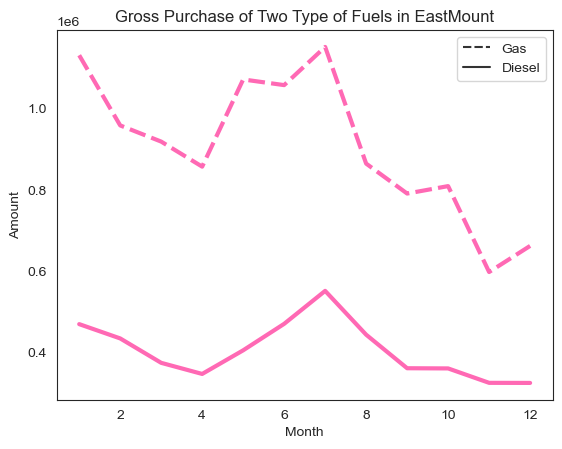

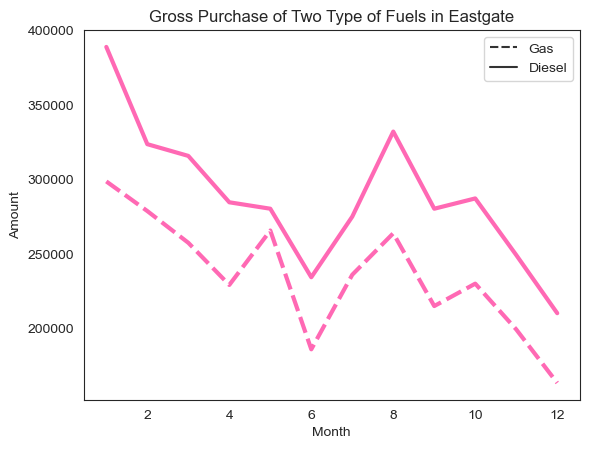

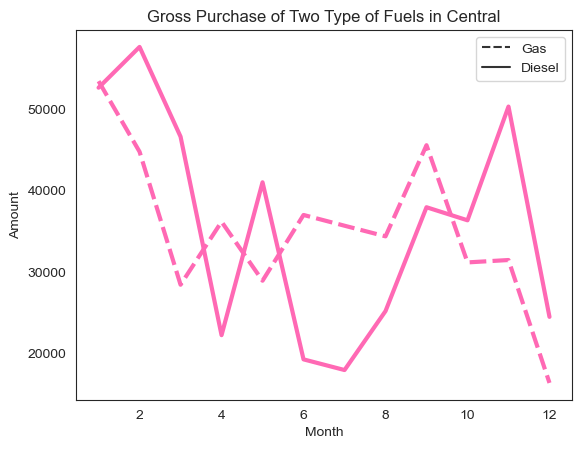

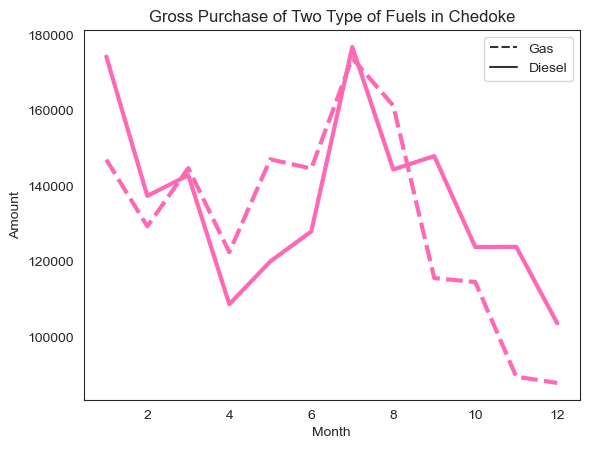

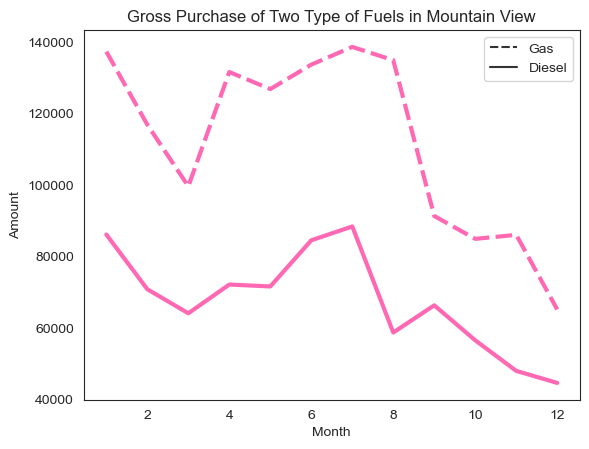

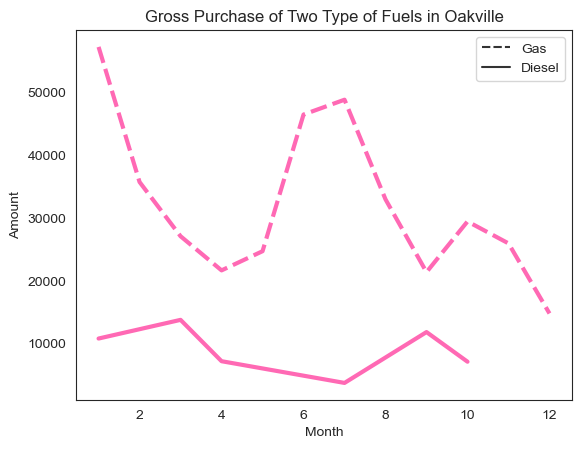

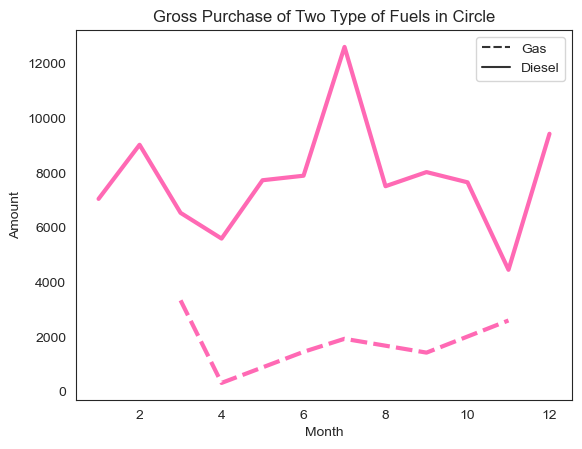

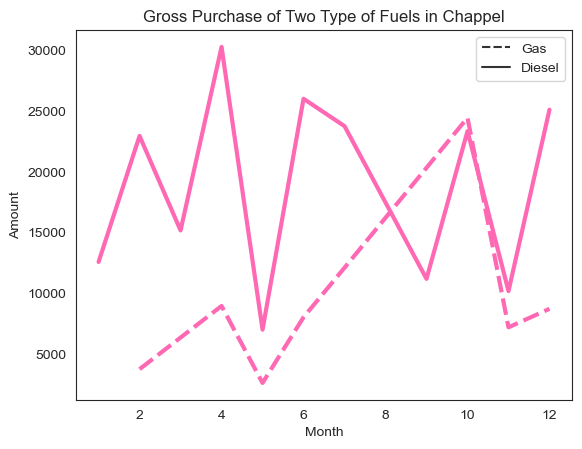

In [30]:
# Plot all stations' purchases of Diesel and Gas for each of the three years. 
# For example, the Diesel purchases for January in the graph are the sum of the Diesel purchases for the three Januarys 
# in the three years 2017, 2018, and 2019
for i in range(1,9):
    sns.set_style('white')
    
    names = list(df_loc["Gas Station Name"])
    name = names[i-1]
    
    df_sta_purchasei = df_station_purchase.groupby("Location").get_group(i)
    axes = sns.lineplot(x = 'Month', y = 'Amount_Purchased', style = 'Fuel_Type', data = df_sta_purchasei, \
                        color = 'hotpink', linewidth = 3)
    
    handles, labels = axes.get_legend_handles_labels() 
    axes.legend(handles=[handles[1], handles[0]], labels=["Gas", "Diesel"])

    
    axes.set(xlabel = "Month", ylabel = "Amount", title = f"Gross Purchase of Two Type of Fuels in {name}")
    plt.show()

# Consumption & Purchasing joint movement

## Calculate monthly data

### Create monthly consumption df

In [31]:
# add month and year columns to df total cons
df_total_cons['month'] = df_total_cons['Timestamp'].dt.month
df_total_cons['year'] = df_total_cons['Timestamp'].dt.year

In [32]:
# create montly cons df
df_monthly_cons = df_total_cons.groupby(by = ['Location', 'month', 'year'], \
                                        as_index = False)[['Total Gas Consumption', \
                                                           'Total Diesel Consumption']].sum()
df_monthly_cons

,Location,month,year,Total Gas Consumption,Total Diesel Consumption
0,1,1,2017,368861.648,161853.896
1,1,1,2018,411133.208,194094.248
2,1,1,2019,344752.048,140729.856
3,1,2,2017,303282.936,121344.040
4,1,2,2018,344045.472,206473.008
...,...,...,...,...,...
241,8,10,2018,7389.000,1972.000
242,8,11,2017,4085.000,1371.000
243,8,11,2018,6821.000,2098.000
244,8,12,2017,5285.000,1412.000


### Create montly purchased df

In [33]:
# add month and year columns to df station
df_station['month'] = df_station['Timestamp'].dt.month
df_station['year'] = df_station['Timestamp'].dt.year

In [35]:
# find monthly data
df_monthly = df_station.groupby(
    by = ['Location', 'month', 'year', 'Fuel_Type'], as_index = False)[
    ['Gross_Purchase_Cost', 'Amount_Purchased' ]].sum()

# seperate data by fuel type
df_monthly_g = df_monthly[df_monthly['Fuel_Type'] == 'G'].drop(columns = 'Fuel_Type')
df_monthly_d = df_monthly[df_monthly['Fuel_Type'] == 'D'].drop(columns = 'Fuel_Type')
df_monthly_g.rename(columns = {'Gross_Purchase_Cost': 'Total Gas Cost', 
                               'Amount_Purchased': 'Total Gas Amount Purchased'}, inplace = True)
df_monthly_d.rename(columns = {'Gross_Purchase_Cost': 'Total Diesel Cost', 
                               'Amount_Purchased': 'Total Diesel Amount Purchased'}, inplace = True)

# merge for df monthly purchase
df_monthly_pur = df_monthly_g.merge(df_monthly_d, on = ['Location', 'month', 'year'], how = 'outer')
df_monthly_pur.head(3)

,Location,month,year,Total Gas Cost,Total Gas Amount Purchased,Total Diesel Cost,Total Diesel Amount Purchased
0,1,1,2017,456032.128,378365.648,206702.313,154160.896
1,1,1,2018,442548.498,420534.208,194433.799,185033.568
2,1,1,2019,386422.224,331507.648,162352.449,130693.856


### Form df monthly for all data combined

In [36]:
# combine consumption and purchase data into one df
df_monthly_joint = df_monthly_cons.merge(df_monthly_pur, on = ['Location', 'month', 'year'], how = 'left')

In [ ]:
# check missing values
df_monthly_joint.isna().any()
df_monthly_joint.isna().sum()

In [38]:
# data cleaning, replace nan for 0
df_monthly_joint[['Total Gas Cost', 'Total Gas Amount Purchased',
                  'Total Diesel Cost', 'Total Diesel Amount Purchased']] = df_monthly_joint[
                ['Total Gas Cost', 'Total Gas Amount Purchased',
                'Total Diesel Cost', 'Total Diesel Amount Purchased']].fillna(0)

# check again to avoid missing values
df_monthly_joint.isna().any()

df_monthly_joint.head()

,Location,month,year,Total Gas Consumption,Total Diesel Consumption,Total Gas Cost,Total Gas Amount Purchased,Total Diesel Cost,Total Diesel Amount Purchased
0,1,1,2017,368861.648,161853.896,456032.128,378365.648,206702.313,154160.896
1,1,1,2018,411133.208,194094.248,442548.498,420534.208,194433.799,185033.568
2,1,1,2019,344752.048,140729.856,386422.224,331507.648,162352.449,130693.856
3,1,2,2017,303282.936,121344.040,378018.613,311051.936,175090.354,130895.104
4,1,2,2018,344045.472,206473.008,376069.127,360733.472,200123.270,189856.128


### Calculating correlation coefficient

In [39]:
# calculate correlation coefficient
# create an empty dict
correlation = {}

# loop for each gas station
for i in range(1,9):
    # find gas station name
    names = list(df_loc["Gas Station Name"])
    n = names[i-1]
    
    # find df for single gas station
    subset = df_monthly_joint[df_monthly_joint['Location'] == i]
    
    # change columns into array for gas
    x1 = np.array(subset["Total Gas Consumption"])
    y1 = np.array(subset["Total Gas Cost"])
  
    # change columns into array for diesel
    x2 = np.array(subset["Total Diesel Consumption"])
    y2 = np.array(subset["Total Diesel Cost"])
    
    # calculate correlation and save distinct value into dict
    c1 = np.corrcoef(x1, y1)[0,1]
    c2 = np.corrcoef(x2, y2)[1,0]
    correlation[n] = [c1,c2]

# c1 for gas correlation and c2 for diesel correlation
# convert dict into df
df_cor = pd.DataFrame(correlation, index = ["Gas", "Diesel"])
df_cor

,EastMount,Eastgate,Central,Chedoke,Mountain View,Oakville,Circle,Chappel
Gas,0.566,0.767,0.659,0.435,0.579,0.530,0.382,0.020
Diesel,0.537,0.828,0.639,0.549,0.410,-0.021,0.142,0.022


## Plot 1 - Scatter plot for monthly fuel consumption and purchasing

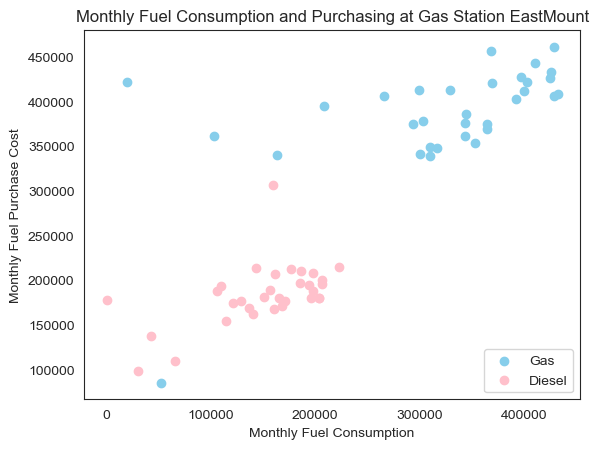

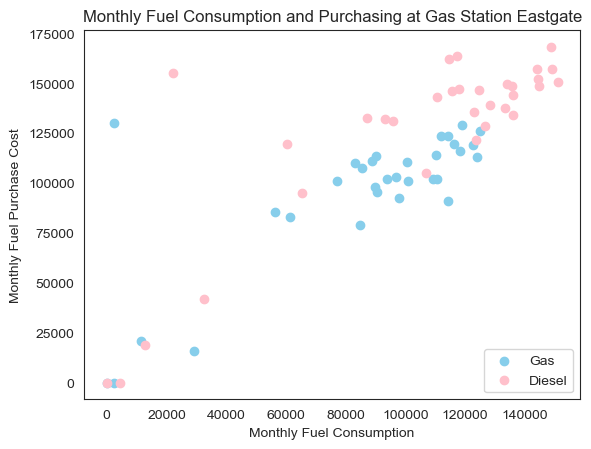

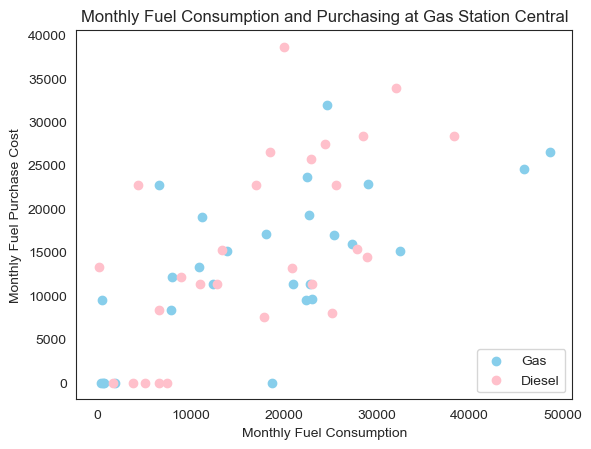

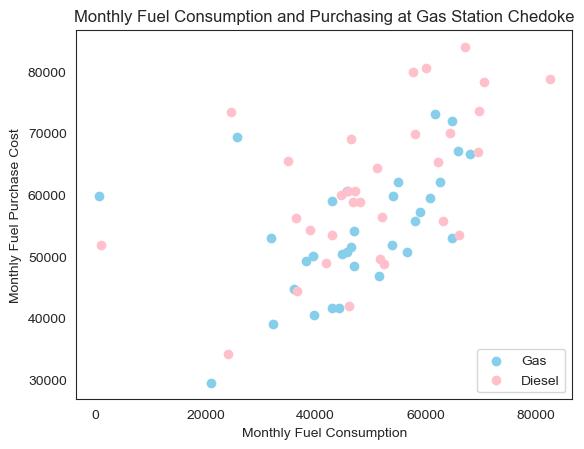

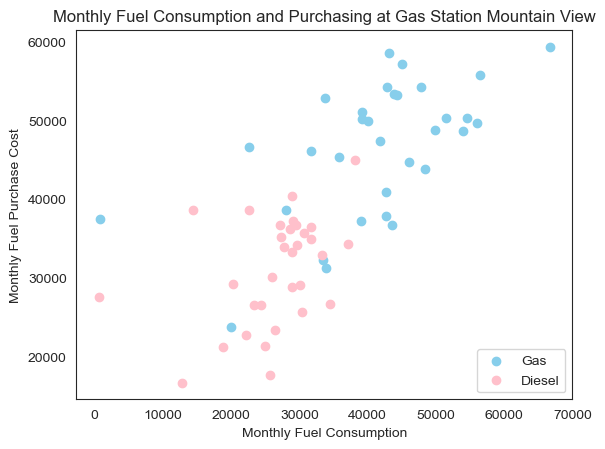

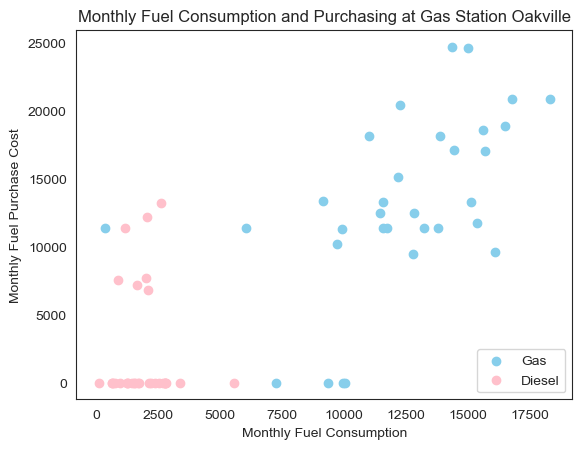

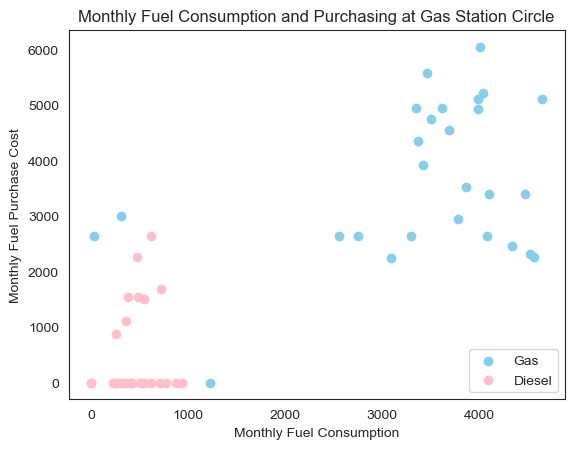

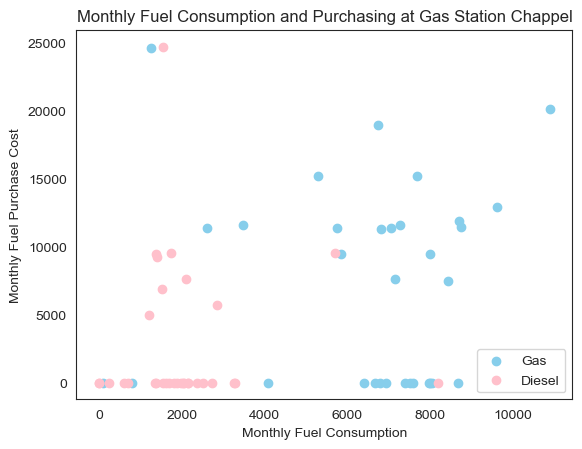

In [41]:
for i in range(1,9):
    # find gas station name
    names = list(df_loc["Gas Station Name"])
    n = names[i-1]
    
    # find df for single gas station
    subset = df_monthly_joint[df_monthly_joint['Location'] == i]
    
    # draw scatter plot
    fig, ax = plt.subplots()
    
    # scatter for each fuel type
    ax.scatter(x = subset["Total Gas Consumption"], y = subset["Total Gas Cost"],
               color="skyblue", label = 'Gas')
    ax.scatter(x = subset["Total Diesel Consumption"], y = subset["Total Diesel Cost"],
               color="pink", label = 'Diesel')
    
    # set titles and labels
    ax.set(title = f'Monthly Fuel Consumption and Purchasing at Gas Station {n}')
    ax.set_xlabel("Monthly Fuel Consumption")
    ax.set_ylabel("Monthly Fuel Purchase Cost")
    plt.legend(loc='lower right')
    plt.show()

## Discount analysis 

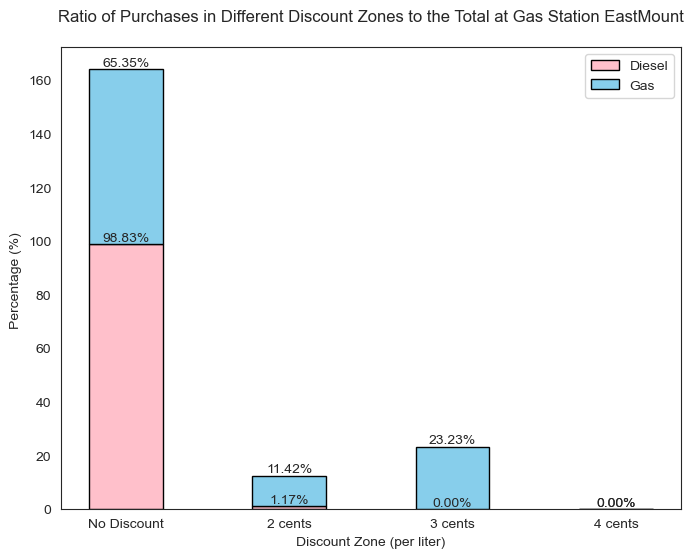

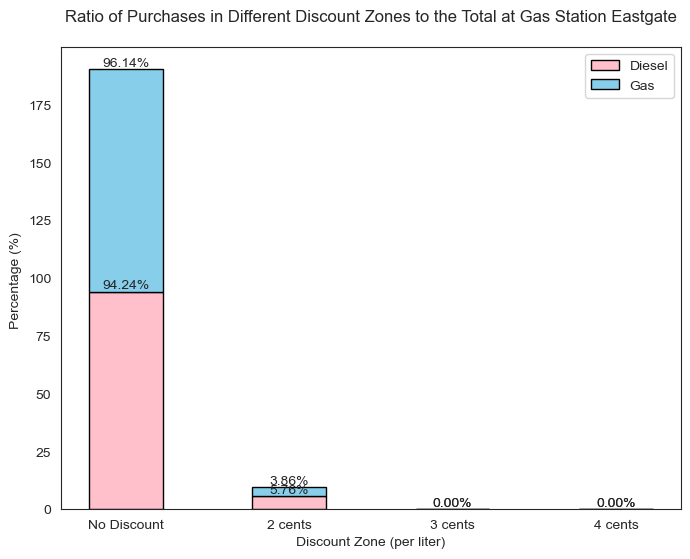

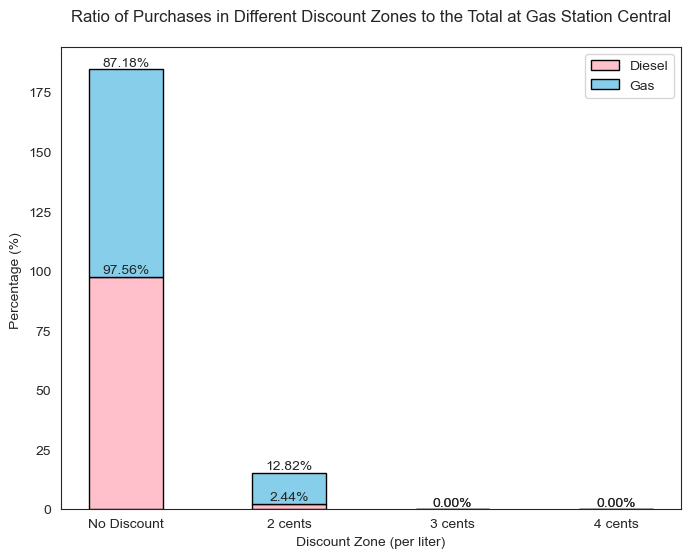

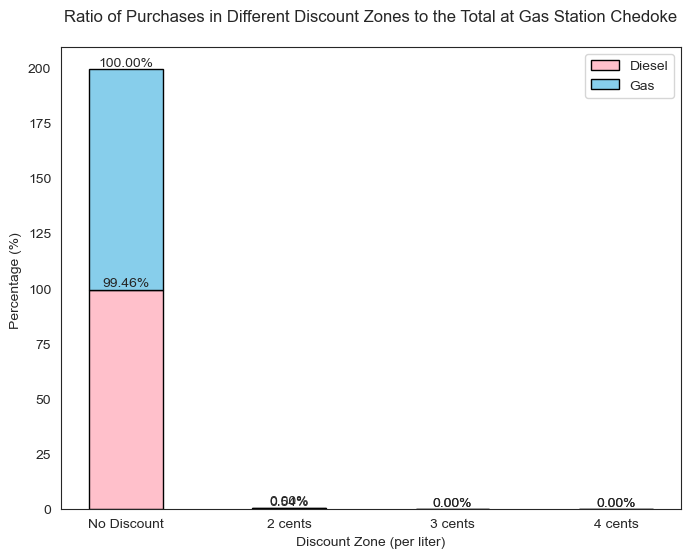

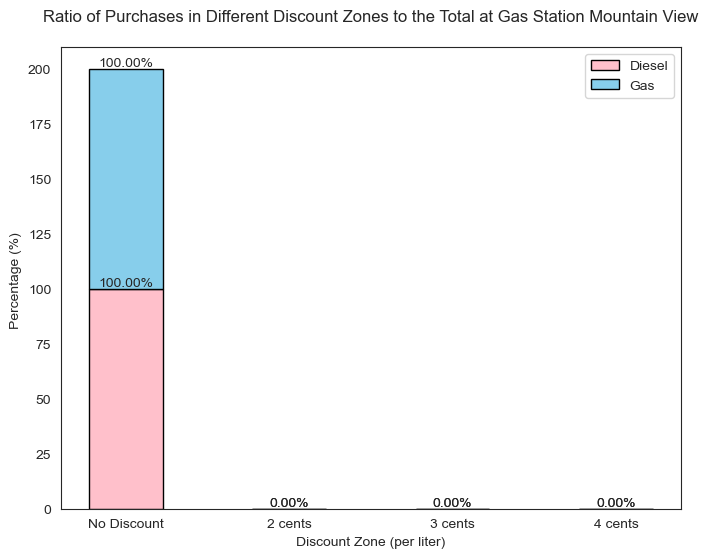

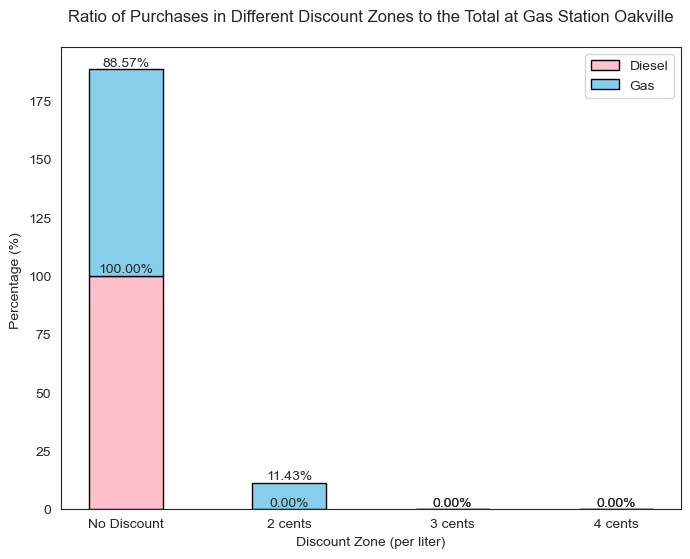

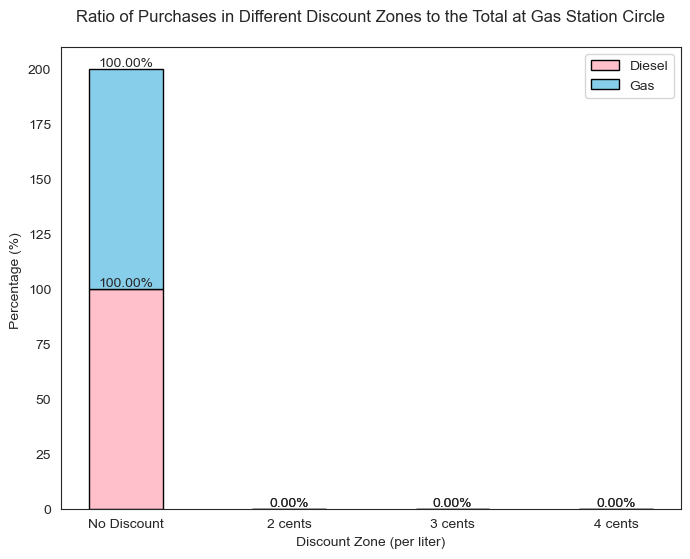

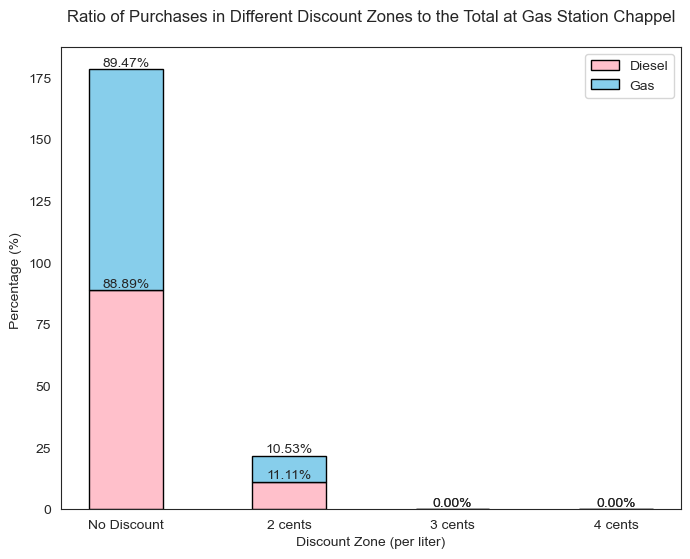

In [42]:
for i in range(1,9):
    names = list(df_loc["Gas Station Name"])
    name = names[i-1]
    
    # get the index of each station using the conditions on the volume of each trade
    df_stationi = df_station[df_station["Location"] == i]
    df_stationi = df_stationi[df_stationi["Location"].notnull()].copy()
    df_stationi[df_stationi.Amount_Purchased <= 15000].index.tolist()
    
    df_stationi.loc[df_stationi[df_stationi.Amount_Purchased <= 15000].index.tolist(),'Volume_Level'] = 1
    df_stationi.loc[df_stationi[(df_stationi.Amount_Purchased <= 25000
                                ) & (df_stationi.Amount_Purchased > 15000)].index.tolist(),'Volume_Level'] = 2
    df_stationi.loc[df_stationi[(df_stationi.Amount_Purchased <= 40000
                                ) & (df_stationi.Amount_Purchased > 25000)].index.tolist(),'Volume_Level'] = 3
    df_stationi.loc[df_stationi[df_stationi.Amount_Purchased > 40000].index.tolist(),'Volume_Level'] = 4
    # Counting how many Diesel purchases are made at each gas station
    df_stationi.loc[(df_stationi['Fuel_Type'] == 'D')].count()
    # Counting how many Gas purchases are made at each gas station
    df_stationi.loc[(df_stationi['Fuel_Type'] == 'G')].count()
    
    # Calculate the proportion of all Gas and Diesel purchases that fall into each purchase volume band, respectively.
    sta_D_l1i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 1.0
                                    ) & (df_stationi['Fuel_Type'] == 'D')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'D')].count()
    sta_D_l2i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 2.0
                                    ) & (df_stationi['Fuel_Type'] == 'D')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'D')].count()
    sta_D_l3i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 3.0
                                    ) & (df_stationi['Fuel_Type'] == 'D')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'D')].count()
    sta_D_l4i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 4.0
                                    ) & (df_stationi['Fuel_Type'] == 'D')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'D')].count()
    
    
    sta_G_l1i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 1.0
                                    ) & (df_stationi['Fuel_Type'] == 'G')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'G')].count()
    sta_G_l2i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 2.0
                                    ) & (df_stationi['Fuel_Type'] == 'G')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'G')].count()
    sta_G_l3i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 3.0
                                    ) & (df_stationi['Fuel_Type'] == 'G')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'G')].count()
    sta_G_l4i = 100*df_stationi.loc[(df_stationi['Volume_Level'] == 4.0
                                    ) & (df_stationi['Fuel_Type'] == 'G')
                                   ].count()/df_stationi.loc[(df_stationi['Fuel_Type'] == 'G')].count()
    
    # make lists
    sta_D_peri = [sta_D_l1i['Location'], sta_D_l2i['Location'], sta_D_l3i['Location'], sta_D_l4i['Location']]
    sta_G_peri = [sta_G_l1i['Location'], sta_G_l2i['Location'], sta_G_l3i['Location'], sta_G_l4i['Location']]
    # plot a stack plot, showing the percentage of the trades buying specific volume of gas and diesel
    sns.set_style('white')
    font = {'family' : 'Times New Roman', 'size' : 2}
    font_value = { 'family': 'Times New Roman', 'size' : 20}
    width = 0.45
    xi = np.array(['No Discount', '2 cents', '3 cents', '4 cents'])
    y_1i = np.array(sta_D_peri)
    y_2i = np.array(sta_G_peri)
    fig, axes = plt.subplots(figsize = (8, 6))
    bar_plot_1i = axes.bar(xi, y_1i, width = 0.45, color = 'pink', edgecolor = 'black')
    bar_plot_2i = axes.bar(xi, y_2i, bottom = y_1i, width = 0.45, color = 'skyblue', edgecolor = 'black')
    axes.set(xlabel = 'Discount Zone (per liter)', ylabel = "Percentage (%) ")
    axes.set_title(f'Ratio of Purchases in Different Discount Zones to the Total at Gas Station {name}\n', 
                   fontsize = 12)
    plt.legend((bar_plot_1i[0],bar_plot_2i[0]),('Diesel','Gas'))
    # adding a numeric scale
    for a,b in zip(xi, y_1i):
        plt.text(a, b-0.005, '%.2f' % b + '%', ha = 'center', va = 'bottom', fontsize = 10)
    for b,c,d in zip(y_1i, xi, y_2i):
        plt.text(c, d+b+0.03, '%.2f' % d + '%', ha = 'center', va = 'bottom', fontsize = 10)

# End of the Project.